# Objetivo: Criar uma GAN para gerar imagens de carros.

Queremos criar uma rede neural adversária generativa para criar imagens a partir do dataset CIFAR10, mas somente dos labels de carros.

Artigo que me baseei para gerar o código: https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/

Como o treinamento de uma GAN é extremamente sensível ao processo de hiperparametrização, adiciono também um guia para identificar e resolver problemas de treinamento com GANs: https://machinelearningmastery.com/practical-guide-to-gan-failure-modes

## Introdução: Importando as imagens e as bibliotecas

In [1]:
import os
import numpy as np
from numpy.random import randint, rand, randn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Conv2D, Conv2DTranspose, Flatten
from tensorflow.keras.layers import Dropout, LeakyReLU, Reshape, BatchNormalization
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.datasets.cifar10 import load_data
from glob import glob
import cv2
from skimage import io 
from skimage.transform import rotate, AffineTransform, warp
from skimage import img_as_ubyte
from skimage.util import random_noise


# Permite à GPU alocar mais memória para o tensorflow
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

Using TensorFlow backend.


# Extra: Aumentando o tamanho do nosso dataset de treinamento

Vamos usar algumas funções para gerar novas imagens de treinamento (Oversampling).

In [2]:
# def anticlockwise_rotation(image):
#     angle = np.random.randint(0, 180)
#     return rotate(image, angle)

# def clockwise_rotation(image):
#     angle = np.random.randint(0, 180)
#     return rotate(image, -angle)

# def horizontal_flip(image):
#     return np.fliplr(image)

# def vertical_flip(image):
#     return np.flipud(image)

# def add_noise(image):
#     return random_noise(image)

# def blur_image(image):
#     return cv2.GaussianBlur(image, (9,9), 0)


# # Mapeando as transformações, armazenando os nomes das funções
# transformations = {'rotate anticlockwise': anticlockwise_rotation,
#                    'rotate clockwise': clockwise_rotation,
#                    'horizontal flip': horizontal_flip,
#                    'vertical flip': vertical_flip,
#                    'add noise': add_noise,
#                    'blur image': blur_image}

In [3]:
# # Criando as imagens novas (oversampling)
# original_images_path = 'oversampling_imgs' # Caminho das imagens de treinamento
# augmented_images_path = 'oversampling_imgs/generated_oversampling_imgs' # Caminho para salvar as imagens geradas
# augmented_images = []

# for im in os.listdir(original_images_path):  # Lê a imagem da pasta e atribui seu caminho ao array "images"
#     augmented_images.append(os.path.join(original_images_path, im))

# images_to_generate = 20000 # Número de imagens a gerar
# i = 1

# while i <= images_to_generate:
#     image = np.random.choice(augmented_images)
#     original_image = io.imread(image, plugin='matplotlib')
#     transformed_image = None
    
#     n = 0  # Iterando até o número de transformações que serão aplicadas
#     transformation_count = np.random.randint(1, len(transformations)) # Escolhe um número aleatório de transformações
    
#     while n <= transformation_count:
#         key = np.random.choice(list(transformations)) # Escolhe uma função de transformação aleatória para chamar
#         transformed_image = transformations[key](original_image)
#         n = n + 1
        
#     new_image_path = "%s/augmented_image_4wave_%s.jpg"%(augmented_images_path, i)
#     transformed_image = img_as_ubyte(transformed_image) # Converte a imagem no formato de bytes, valores entre 0 e 255
#     transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_BGR2RGB) # Converte a imagem para RGB antes de salvar
#     cv2.imwrite(new_image_path, transformed_image) # Salvando a imagem transformada para o caminho
    
#     i = i + 1

In [4]:
# # Criando as instâncias dos geradores de dados de treinamento e teste
# train_path = "cars_data/train"  # Caminho dos dados de treinamento
# train_image_files = glob(train_path + '/*/*.jpg')  # Imagens de treinamento
# IMAGE_SIZE = [32, 32]  # Tamanho das imagens que serão geradas


# # Criando o objeto que gerará as imagens
# g_train_obj = ImageDataGenerator(
#   preprocessing_function=preprocess_input
# )


# # Criando os batches de imagens de treinamento a partir dos geradores
# train_batch = g_train_obj.flow_from_directory(train_path, shuffle=True, 
#                                                   target_size=IMAGE_SIZE, 
#                                                   classes=['cars', 'no cars'],
#                                                   batch_size=16191) # Nümero de imagens total, apenas 1 batch

In [5]:
# # Dimensão das imagens criadas (entrando dentro do train batch e pegando o item 1, que é o chunk de 14048 imagens)
# train_batch[0][0].shape = (16191, 32, 32, 3)

In [6]:
# # Mostrando uma imagem de exemplo do dataset carregado
# plt.imshow(train_batch[0][0][0])
# plt.show()

# Parte 1: Treinando o modelo discriminante

Vamos primeiro treinar o modelo discriminante em algumas imagens geradas com ruído (falsas) e algumas imagens reais.

In [7]:
# Função para criar o modelo discriminante (adversário)
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential([
        Conv2D(64, (3,3), padding='same', input_shape=in_shape), #activation='relu'), # Já passa o tamanho do input direto na Conv2D Layer
        #BatchNormalization(),
        LeakyReLU(alpha=0.2),
        
        Conv2D(128, (3,3), strides=(2,2), padding='same'), #activation='relu'), # de 32x32 para 16x16
        #BatchNormalization(),
        LeakyReLU(alpha=0.2),
        
        Conv2D(128, (3,3), strides=(2,2), padding='same'), #activation='relu'), # de 16x16 para 8x8
        #BatchNormalization(),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3,3), strides=(2,2), padding='same'), #activation='relu'), # de 8x8 para 4x4
        #BatchNormalization(),
        LeakyReLU(alpha=0.2),
        
        #Conv2D(256, (3,3), strides=(2,2), padding='same'), #activation='relu'), # Usar essa layer se a img for 64x64
        #BatchNormalization(),
        #LeakyReLU(alpha=0.2),
        
        Flatten(), # Dimensão dos feature maps finais: 4x4
        Dropout(0.2),
        Dense(1, activation='sigmoid')
    ])

    # Compilando o modelo discriminante
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    
    return model

In [8]:
# # Convertendo os valores dos pixels das imagens reais para float32 e normalizando os valores para -1 até 1
# def load_real_samples(train_batch):
#     x_train = train_batch[0][0]

#     # Transformando os valores de dentro do train batch em float32 e atribuindo à lista z
#     x = x_train.astype('float32')

#     # Normalizando os valores de [0, 255] para [-1, 1], pois o modelo gerador gerará valores de -1 até 1,
#     # usando a activation function tanH, como a boa prática recomenda.
#     x = (x - 127.5) / 127.5
    
#     return x

def load_real_samples():
    
    # Criando o objeto cifar10
    cifar10 = tf.keras.datasets.cifar10
    
    # Carregando o dataset com X e Y, para selecionar apenas uma classe específica
    (x_train, y_train), (_, _) = cifar10.load_data()
    
    # Selecionando apenas os carros
    idx = (y_train == 1).reshape(x_train.shape[0]) # No Cifar10, o index "1" é o dos carros.
    x_train_cars = x_train[idx] 
    
    # Convertendo os dados para float32
    x = x_train_cars.astype('float32')
    
    # Convertendo os dados de (0, 255) para (-1, 1)
    x = (x - 127.5) / 127.5
    
    return x

In [9]:
# A função abaixo recebe os dados de treinamento como parâmetro e seleciona uma amostra aleatória de imagens.
# Também retorna os as classes da amostra, especificamente labels 1, indicando amostras reais.


# Selecionando imagens reais da base de treino e atribuindo a classe 1
def generate_real_samples(dataset, n_samples):
    
    # Escolhendo imagens aleatórias
    ix = randint(0, dataset.shape[0], n_samples)
    
    # Atribuindo as imagens aleatórias a X
    x = dataset[ix]
    
    # Atribuindo a classe 1 às imagens reais
    y = np.ones((n_samples, 1))
    
    return x, y

In [10]:
# O modelo gerador ainda não foi criado. Podemos gerar imagens com valores de pixels aleatórios, especificamente
# pixels entre 0 e 1, e depois transformá-los em valores entre -1 e 1, na mesma escala das nossas imagens reais.
# A função abaixo implementa esse comportamento e gera imagens de valores aleatórios de pixels, associando à elas
# a classe 0 (imagens fake).


# Gerando n fake samples com classe 0
def generate_fake_samples(n_samples):
    
    # Gerando ruído aleatório (números uniformes entre 0 e 1)
    x = rand(32 * 32 * 3 * n_samples)
    
    # Atualizando X para que tenha range entre (-1, 1)
    x = -1 + x * 2
    
    # Redimensionando para o formato de imagens coloridas
    x = x.reshape((n_samples, 32, 32, 3))

    # Atribuindo a classe 0 às imagens falsas
    y = np.zeros((n_samples, 1))
    
    return x, y

In [11]:
# Criando o modelo discriminante
discriminator_model = define_discriminator()

# Carregando as imagens reais
discriminator_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         2

# Parte 2: Construindo o modelo gerador

Agora vamos construir o modelo gerador.

In [12]:
# Definindo o modelo gerador
def define_generator(latent_dim):
    # Dimensão dos feature maps que transformaremos em imagens novamente
    n_nodes = 256 * 4 * 4     # 4.096: (256 * 4 * 4) -> Necessário para imagens 32 x 32
                              # 16.384: (1.024 * 4 * 4) -> Necessário para imagens 64 x 64
                              # Para imagens 128x128, (1.024 * 4) * 4 * 4 -> 4096 * 4 * 4(65.536)

    model = Sequential([
        Dense(n_nodes, input_dim=latent_dim), #activation='relu'),
        Reshape((4, 4, 256)),
        #BatchNormalization(),
        LeakyReLU(alpha=0.2),
        

        # Aumentando a imagem (Conv2DTranspose), que foi diminuída nas strided convolutions da discriminator, para 8x8
        Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'), #activation='relu'),
        #BatchNormalization(),
        LeakyReLU(alpha=0.2),

        # 16x16
        Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'), #activation='relu'),
        #BatchNormalization(),
        LeakyReLU(alpha=0.2),

        # 32x32
        Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'), #activation='relu'),
        #BatchNormalization(),
        LeakyReLU(alpha=0.2),
        
        # 64 x 64
        #Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'), #activation='relu'),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.2),
        
        # 128 x 128
        #Conv2DTranspose(256, (4,4), strides=(2,2), padding='same'), #activation='relu'),
        #BatchNormalization(),
        #LeakyReLU(alpha=0.2),

        # Camada do output
        Conv2D(3, (3,3), activation='tanh', padding='same') # Garantindo a imagem com 3 dimensões
    ])
    
    return model

In [13]:
# Nesse momento, o modelo não tem muita usabilidade. Porém, podemos mostrar como podemos usá-lo para gerar amostras.
# EIsso nos ajuda a visualizar a rede geradora como simplesmente um outro modelo, essa forma de enxergá-la será
# útil para nós depois. O primeiro passo é gerar pontos no espaço latente. Podemos fazer isso chamando a função randn()
# do Numpy, gerando arrays de números aleatórios extraídos de uma distribuição gaussiana. A função abaixo implementa 
# esse comportamento, gerando pontos no espaço latente que servem de input para o modelo gerador.


# Gerando ruído aleatório no espaço latente para servir de input para o modelo gerador
def generate_latent_points(latent_dim, n_samples):
    # Gerando os pontos no espaço latente
    x_input = randn(latent_dim * n_samples)
    
    # Redimensionando em um batch de inputs para a rede geradora
    x_input = x_input.reshape(n_samples, latent_dim)
    return x_input

In [14]:
# O próximo passo é usar os pontos gerados acima como input para o modelo gerador. Ele usará esses pontos para gerar
# novas amostras, e então plotá-las. A função abaixo serve para isso, e retorna tanto as amostras geradas quanto
# o label associado à elas (atribuimos o label 1 a essas imagens).


# Usando o gerador para gerar N exemplos fake, com class label como '0'
def generate_fake_samples(generator_model, latent_dim, n_samples):
    # Gerando os pontos no espaço latente
    x_input = generate_latent_points(latent_dim, n_samples)
    
    # Gerando as amostras das imagens fake
    x = generator_model.predict(x_input)
    
    # Atribuindo o label 'fake' ás imagens fake (0)
    y = np.zeros((n_samples, 1))
    
    return x, y

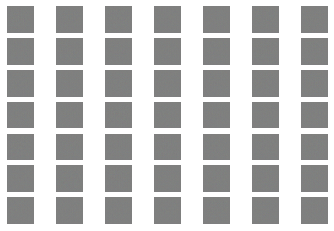

In [15]:
# Tamanho do espaço latente
latent_dim = 100

# Criando o modelo gerador
generator_model = define_generator(latent_dim)

# Gerando as imagens
n_samples = 49
x, _ = generate_fake_samples(generator_model, latent_dim, n_samples)

# Normalizando os valores dos pixels de [-1, 1] para [0, 1] para o plot
x = (x + 1) / 2.0

# Plotando as imagens geradas
for i in range(n_samples):
    # Definindo os subplots
    plt.subplot(7, 7, 1 + i)
    
    # Tirando os labels dos eixos
    plt.axis('off')
    
    # Plotando uma imagem
    plt.imshow(x[i])
    
# Mostrando as imagens.
plt.show()


# Como o modelo ainda não está treinado, as imagens serão apenas pontos aleatórios no espaço latente.

# Parte 3: Treinando o modelo gerador
Para finalizar, vamos treinar o modelo gerador para que ele não gere apenas ruído aleatório.

## Explicação do treinamento de uma GAN

Um modelo GAN é basicamente um modelo que "empilha" as redes geradora e discriminante, de forma que a rede geradora recebe pontos aleatórios no espaço latente como input e gera amostras que são diretamente recebidas pelo modelo discriminante e classificadas. Então, o output do modelo discriminante pode ser usado para atualizar os pesos do
modelo gerador. 

A partir do momento que os pesos do modelo gerador são atualizados, o processo se reinicia, e as imagens produzidas pela rede geradora vão "melhorando".

A rede discriminante se preocupa em diferenciar amostras reais e fake. Treinamos esse modelo separadamente (como fizemos na parte 1).

Sobre o modelo gerador, a sua preocupação é com a performance do modelo discriminante em exemplos fake. Para treinarmos 
a GAN como um todo, atualizamos apenas os parâmetros do modelo gerador e congelamos os parâmetros do modelo discriminante: assim, evitamos de alterar os parâmetros do modelo discriminante com imagens fake.

Obs.: ao treinar uma GAN, queremos que o modelo discriminante pense que as amostras fake geradas as pela rede discriminante são reais. Por isso na função "generate_fake_samples", atribuímos o label 1 para a imagem fake gerada pela rede geradora.

Por que fazemos isso?

Provavelmente, a rede geradora classificará a imagem fake como "não real" (0), ou com uma baixa probabilidade de ser real. O processo de backpropagation usado para atualizar os parâmetros da rede geradora considerará isso como um erro, atualizando assim os pesos do modelo gerador com o objetivo de corrigir esse suposto erro.

Isso faz com que a rede geradora fique cada vez melhor em gerar imagens fake (as imagens geradas ficam cada vez mais parecidas com a realidade).

A função "define_gan" abaixo serve basicamente para criar um modelo combinado com o modelo gerador e o modelo discriminante.

In [16]:
# Definindo o modelo combinado (Gerador + discriminante), para atualização dos parametros do gerador
def define_gan(generator_model, discriminator_model):
    discriminator_model.trainable = False # Os pesos atualizados são somente os da rede geradora
    
    # Conectando os modelos
    model = Sequential()
    
    # Parte 1: Gerador
    model.add(generator_model)
    
    # Parte 2: Discriminante
    model.add(discriminator_model)
    
    # Compilando o modelo
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt) # Classificação binária: Imagem é falsa ou verdadeira
    
    return model

In [17]:
# Criando o modelo combinado (Gerador + Discriminante)
gan_model = define_gan(generator_model, discriminator_model)

gan_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 32, 32, 3)         1466115   
_________________________________________________________________
sequential (Sequential)      (None, 1)                 522497    
Total params: 1,988,612
Trainable params: 1,466,115
Non-trainable params: 522,497
_________________________________________________________________


In [18]:
# # Criando uma função para resumir a performance do modelo

# # Avaliando o discriminante, plotando as imagens geradas, salvando o modelo gerador
# def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
#     # Preparando as amostras reais
#     x_real, y_real = generate_real_samples(dataset, n_samples)
    
#     # Avaliando o discriminante nas amostras reais
#     _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    
#     # Preparando os exemplos fake
#     x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    
#     # Avaliando o discriminante nos exemplos fake
#     _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    
#     # Resumindo a performance do discriminante
#     print('> Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))

In [19]:
# Treinando as duas redes: Geradora e discriminante
def train(generator_model, discriminator_model, gan_model, dataset, latent_dim, n_epochs=500, n_batch=64):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    
    
    # Numerando as epochs manualmente
    for i in range(n_epochs):
        
        # Enumerando os batches sobre todos os dados de treinamento
        for j in range(bat_per_epo):


            ##### PARTE 1 - REDE DISCRIMINANTE #####

            # Selecionando samples reais aleatoriamente
            x_real, y_real = generate_real_samples(dataset, half_batch)

            # Atualizando os pesos do modelo discriminante
            discriminator_loss_real, _ = discriminator_model.train_on_batch(x_real, y_real)

            # Gerando os exemplos 'fake'
            x_fake, y_fake = generate_fake_samples(generator_model, latent_dim, half_batch)

            # Atualizando os pesos do modelo discriminante
            discriminator_loss_fake, _ = discriminator_model.train_on_batch(x_fake, y_fake)


            
            ##### PARTE 2 - REDE GERADORA #####

            # Preparando os pontos no espaço latente como input para a rede geradora
            x_gan = generate_latent_points(latent_dim, n_batch)

            # Criando labels 'falsos' para as imagens geradas (dizendo que elas são reais)
            y_gan = np.ones((n_batch, 1))

            # Atualizando os pesos da geradora através do erro da discriminante
            generator_loss = gan_model.train_on_batch(x_gan, y_gan)

            # Loss na batch específica
            #print('-> Epoch %d, Batch numero %d/%d -> Disc. loss on real images: %.5f, Disc. loss on fake images: %.5f, Generator loss: %.5f' %
            #(i+1, j+1, bat_per_epo, discriminator_loss_real, discriminator_loss_fake, generator_loss))    
            
            
        # Mostrando uma imagem a cada epoch para verificar se a geradora está melhorando    
        z_noise = np.random.normal(0, 1, size=(n_batch, latent_dim))
        gen_images = generator_model.predict_on_batch(z_noise)
        gen_images = (gen_images + 1) / 2.0

        print("")
        print("---------- Imagem gerada na epoch", i, " ----------")
        plt.imshow(gen_images[0])
        plt.show()
        
        # Removendo a imagem para não armazenar nesse array todas as imagens geradas
        gen_images = np.delete(gen_images, 0) # O parâmetro '0' é o index do item que quero deletar

                
        # Avaliando a performance do modelo de vez em quando
        #if (i+1) % 10 == 0:
            #summarize_performance(i, generator_model, discriminator_model, dataset, latent_dim)


---------- Imagem gerada na epoch 0  ----------


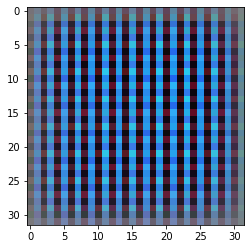


---------- Imagem gerada na epoch 1  ----------


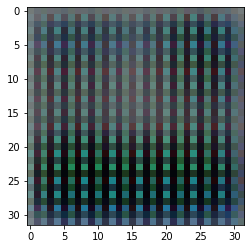


---------- Imagem gerada na epoch 2  ----------


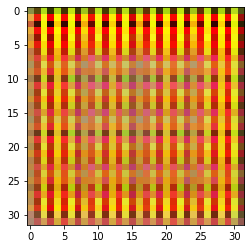


---------- Imagem gerada na epoch 3  ----------


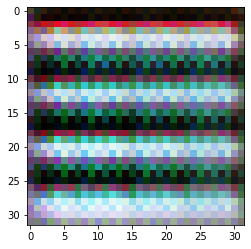


---------- Imagem gerada na epoch 4  ----------


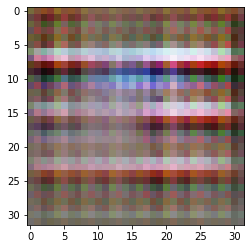


---------- Imagem gerada na epoch 5  ----------


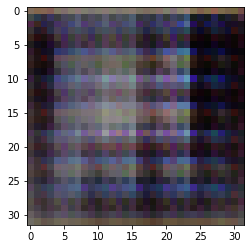


---------- Imagem gerada na epoch 6  ----------


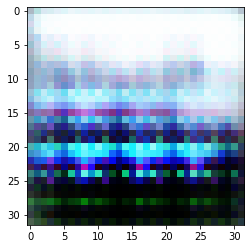


---------- Imagem gerada na epoch 7  ----------


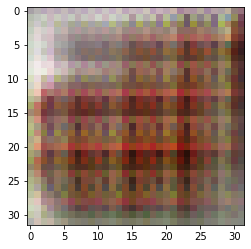


---------- Imagem gerada na epoch 8  ----------


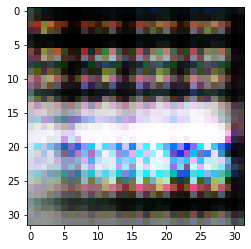


---------- Imagem gerada na epoch 9  ----------


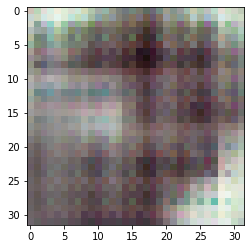


---------- Imagem gerada na epoch 10  ----------


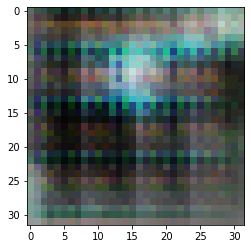


---------- Imagem gerada na epoch 11  ----------


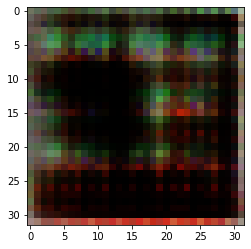


---------- Imagem gerada na epoch 12  ----------


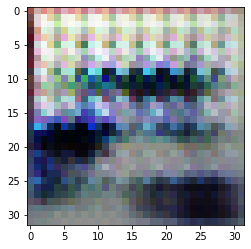


---------- Imagem gerada na epoch 13  ----------


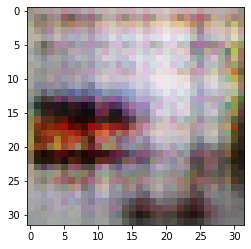


---------- Imagem gerada na epoch 14  ----------


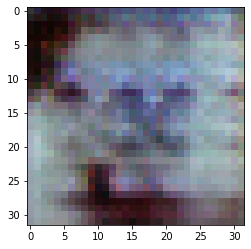


---------- Imagem gerada na epoch 15  ----------


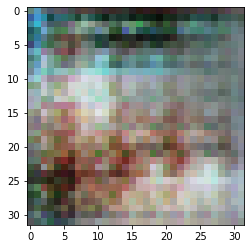


---------- Imagem gerada na epoch 16  ----------


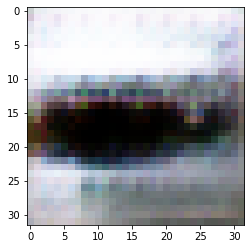


---------- Imagem gerada na epoch 17  ----------


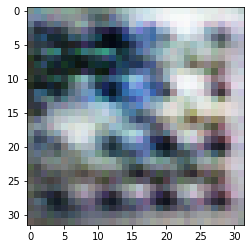


---------- Imagem gerada na epoch 18  ----------


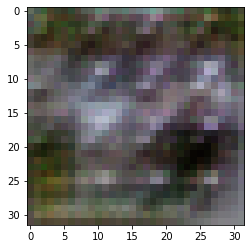


---------- Imagem gerada na epoch 19  ----------


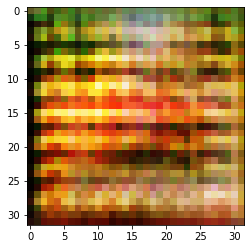


---------- Imagem gerada na epoch 20  ----------


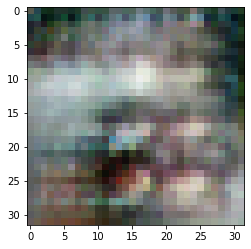


---------- Imagem gerada na epoch 21  ----------


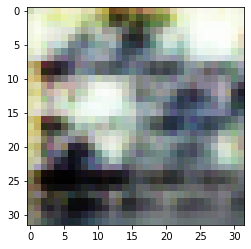


---------- Imagem gerada na epoch 22  ----------


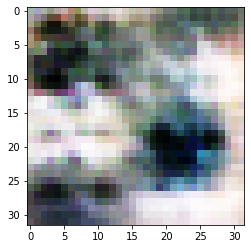


---------- Imagem gerada na epoch 23  ----------


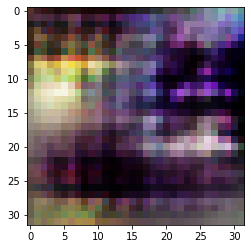


---------- Imagem gerada na epoch 24  ----------


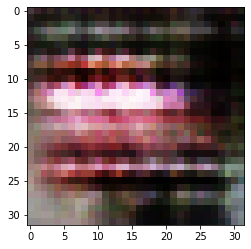


---------- Imagem gerada na epoch 25  ----------


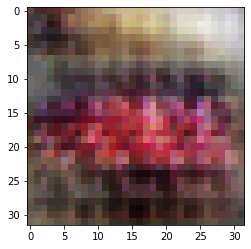


---------- Imagem gerada na epoch 26  ----------


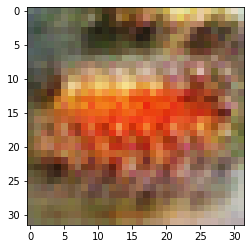


---------- Imagem gerada na epoch 27  ----------


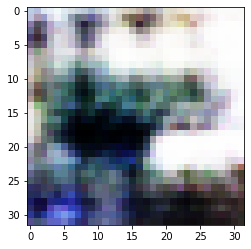


---------- Imagem gerada na epoch 28  ----------


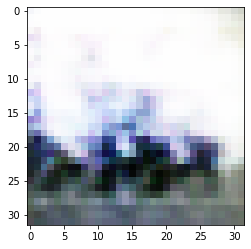


---------- Imagem gerada na epoch 29  ----------


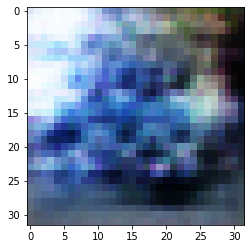


---------- Imagem gerada na epoch 30  ----------


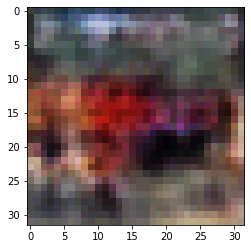


---------- Imagem gerada na epoch 31  ----------


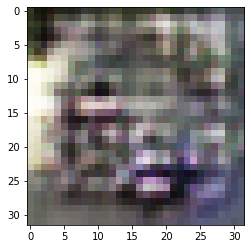


---------- Imagem gerada na epoch 32  ----------


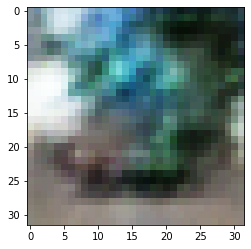


---------- Imagem gerada na epoch 33  ----------


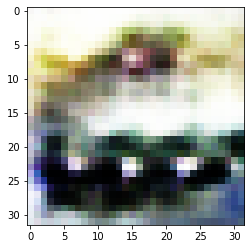


---------- Imagem gerada na epoch 34  ----------


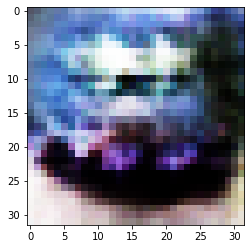


---------- Imagem gerada na epoch 35  ----------


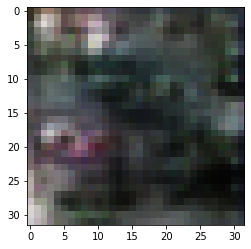


---------- Imagem gerada na epoch 36  ----------


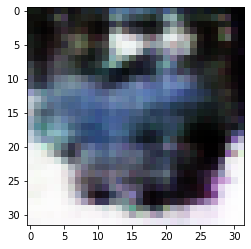


---------- Imagem gerada na epoch 37  ----------


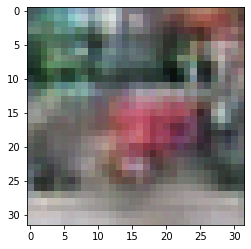


---------- Imagem gerada na epoch 38  ----------


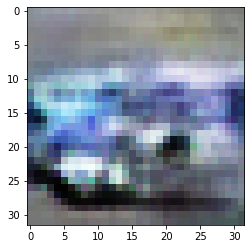


---------- Imagem gerada na epoch 39  ----------


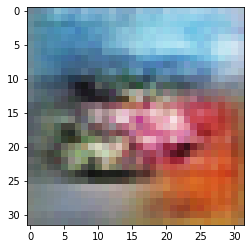


---------- Imagem gerada na epoch 40  ----------


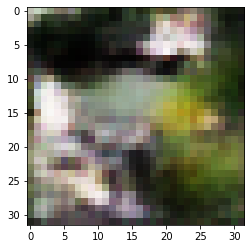


---------- Imagem gerada na epoch 41  ----------


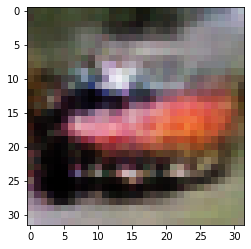


---------- Imagem gerada na epoch 42  ----------


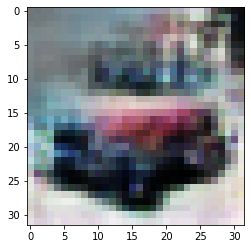


---------- Imagem gerada na epoch 43  ----------


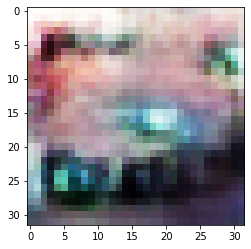


---------- Imagem gerada na epoch 44  ----------


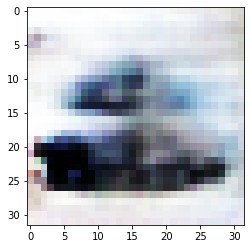


---------- Imagem gerada na epoch 45  ----------


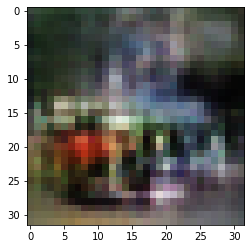


---------- Imagem gerada na epoch 46  ----------


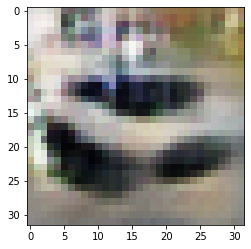


---------- Imagem gerada na epoch 47  ----------


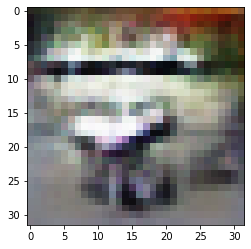


---------- Imagem gerada na epoch 48  ----------


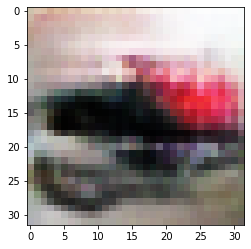


---------- Imagem gerada na epoch 49  ----------


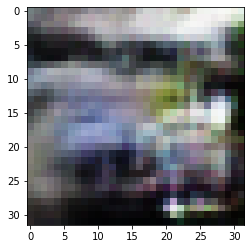


---------- Imagem gerada na epoch 50  ----------


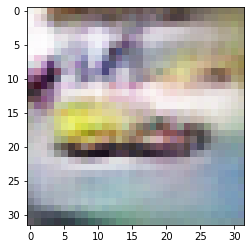


---------- Imagem gerada na epoch 51  ----------


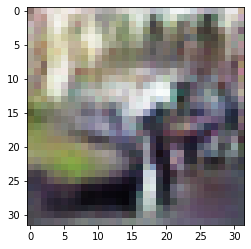


---------- Imagem gerada na epoch 52  ----------


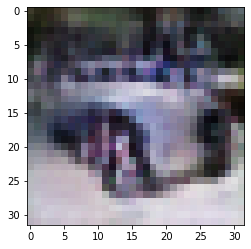


---------- Imagem gerada na epoch 53  ----------


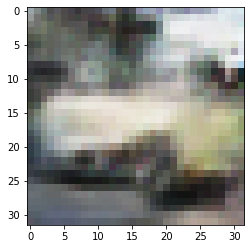


---------- Imagem gerada na epoch 54  ----------


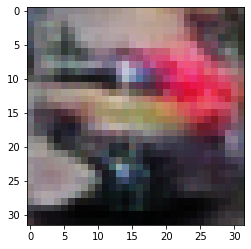


---------- Imagem gerada na epoch 55  ----------


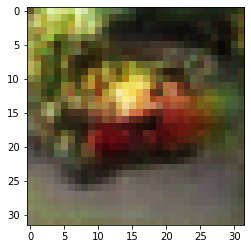


---------- Imagem gerada na epoch 56  ----------


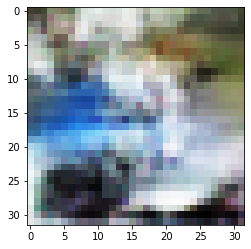


---------- Imagem gerada na epoch 57  ----------


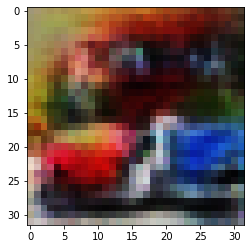


---------- Imagem gerada na epoch 58  ----------


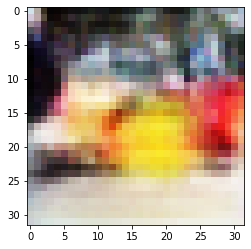


---------- Imagem gerada na epoch 59  ----------


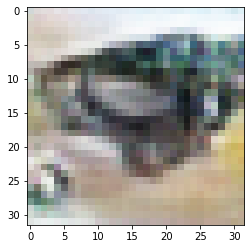


---------- Imagem gerada na epoch 60  ----------


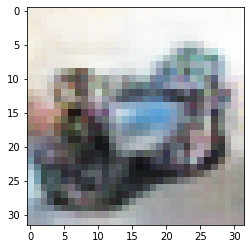


---------- Imagem gerada na epoch 61  ----------


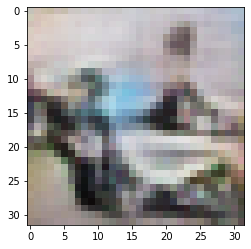


---------- Imagem gerada na epoch 62  ----------


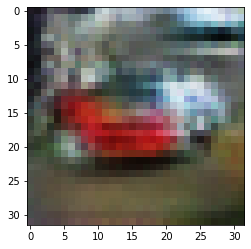


---------- Imagem gerada na epoch 63  ----------


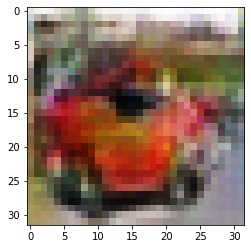


---------- Imagem gerada na epoch 64  ----------


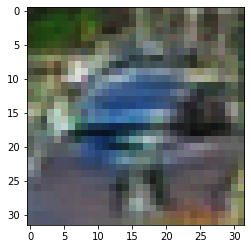


---------- Imagem gerada na epoch 65  ----------


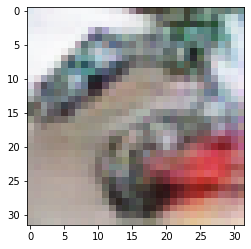


---------- Imagem gerada na epoch 66  ----------


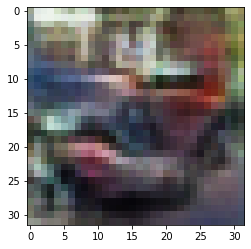


---------- Imagem gerada na epoch 67  ----------


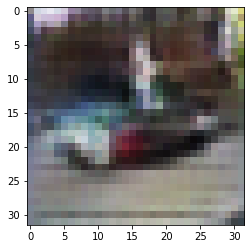


---------- Imagem gerada na epoch 68  ----------


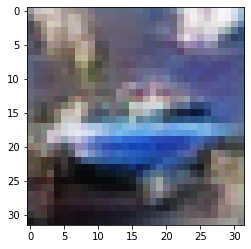


---------- Imagem gerada na epoch 69  ----------


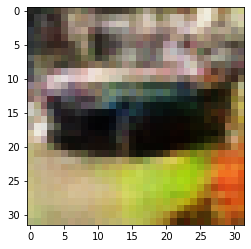


---------- Imagem gerada na epoch 70  ----------


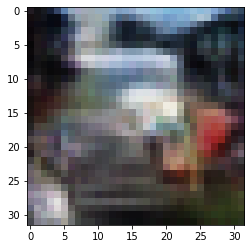


---------- Imagem gerada na epoch 71  ----------


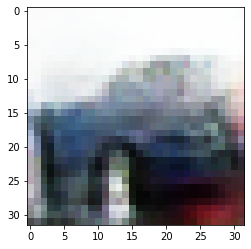


---------- Imagem gerada na epoch 72  ----------


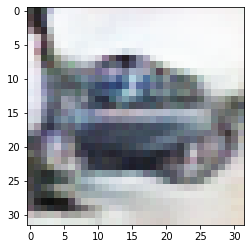


---------- Imagem gerada na epoch 73  ----------


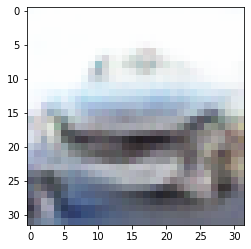


---------- Imagem gerada na epoch 74  ----------


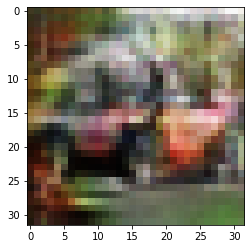


---------- Imagem gerada na epoch 75  ----------


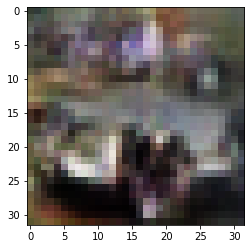


---------- Imagem gerada na epoch 76  ----------


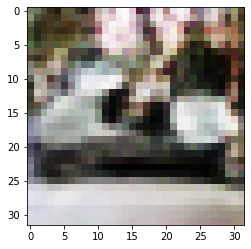


---------- Imagem gerada na epoch 77  ----------


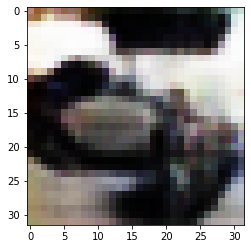


---------- Imagem gerada na epoch 78  ----------


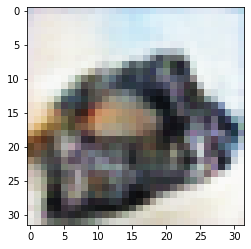


---------- Imagem gerada na epoch 79  ----------


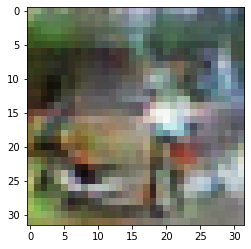


---------- Imagem gerada na epoch 80  ----------


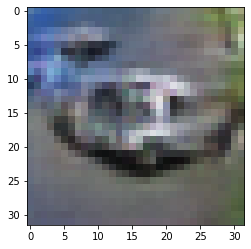


---------- Imagem gerada na epoch 81  ----------


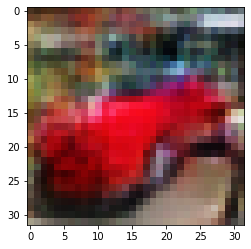


---------- Imagem gerada na epoch 82  ----------


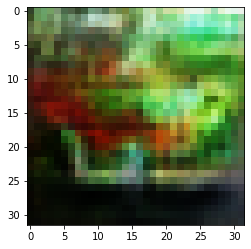


---------- Imagem gerada na epoch 83  ----------


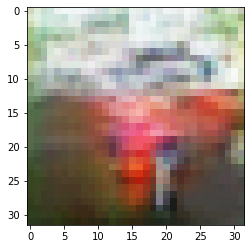


---------- Imagem gerada na epoch 84  ----------


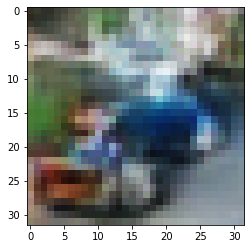


---------- Imagem gerada na epoch 85  ----------


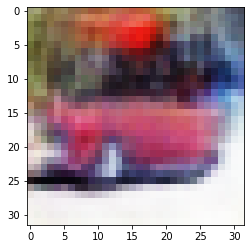


---------- Imagem gerada na epoch 86  ----------


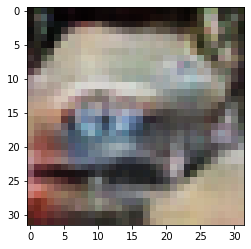


---------- Imagem gerada na epoch 87  ----------


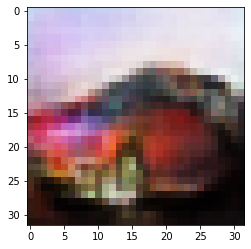


---------- Imagem gerada na epoch 88  ----------


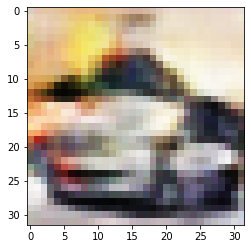


---------- Imagem gerada na epoch 89  ----------


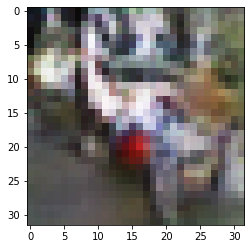


---------- Imagem gerada na epoch 90  ----------


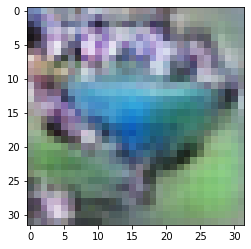


---------- Imagem gerada na epoch 91  ----------


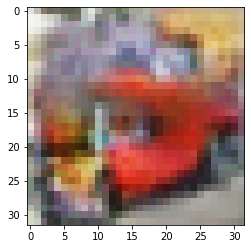


---------- Imagem gerada na epoch 92  ----------


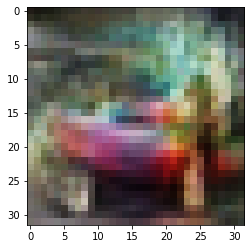


---------- Imagem gerada na epoch 93  ----------


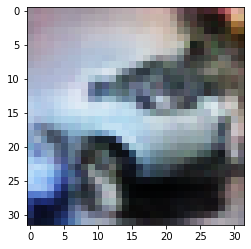


---------- Imagem gerada na epoch 94  ----------


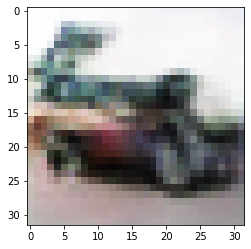


---------- Imagem gerada na epoch 95  ----------


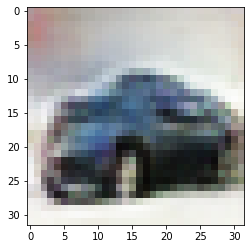


---------- Imagem gerada na epoch 96  ----------


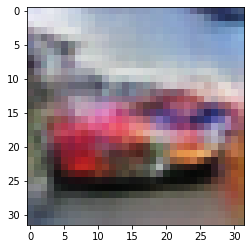


---------- Imagem gerada na epoch 97  ----------


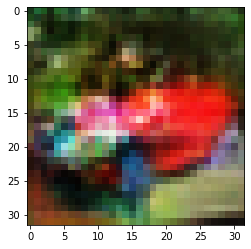


---------- Imagem gerada na epoch 98  ----------


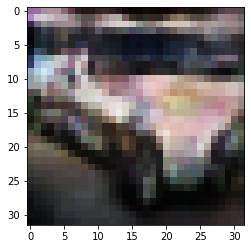


---------- Imagem gerada na epoch 99  ----------


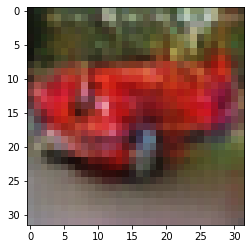


---------- Imagem gerada na epoch 100  ----------


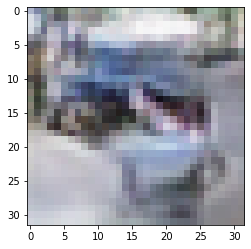


---------- Imagem gerada na epoch 101  ----------


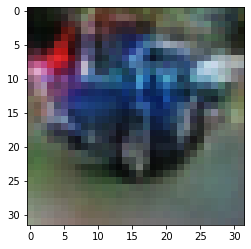


---------- Imagem gerada na epoch 102  ----------


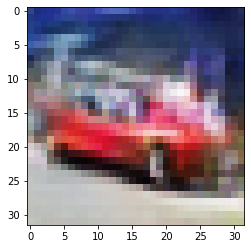


---------- Imagem gerada na epoch 103  ----------


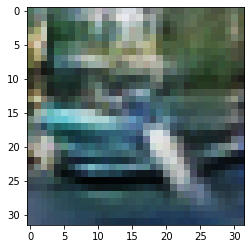


---------- Imagem gerada na epoch 104  ----------


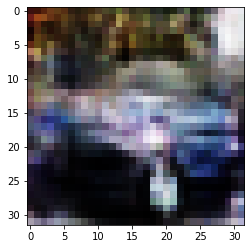


---------- Imagem gerada na epoch 105  ----------


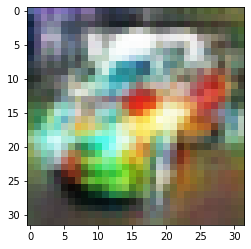


---------- Imagem gerada na epoch 106  ----------


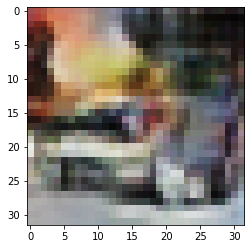


---------- Imagem gerada na epoch 107  ----------


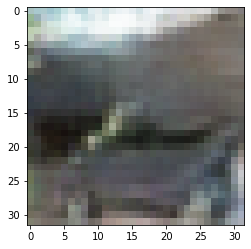


---------- Imagem gerada na epoch 108  ----------


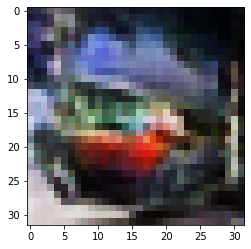


---------- Imagem gerada na epoch 109  ----------


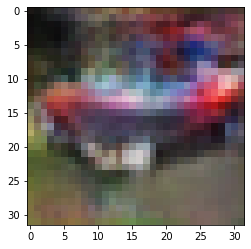


---------- Imagem gerada na epoch 110  ----------


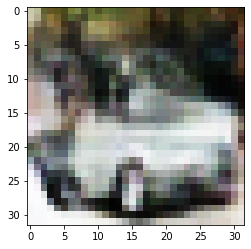


---------- Imagem gerada na epoch 111  ----------


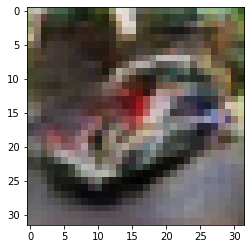


---------- Imagem gerada na epoch 112  ----------


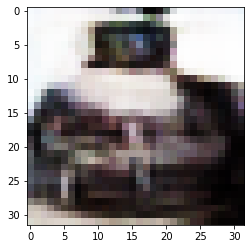


---------- Imagem gerada na epoch 113  ----------


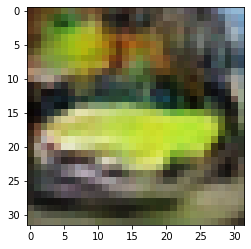


---------- Imagem gerada na epoch 114  ----------


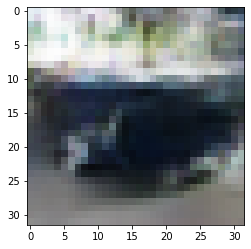


---------- Imagem gerada na epoch 115  ----------


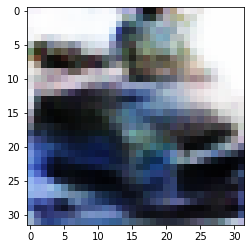


---------- Imagem gerada na epoch 116  ----------


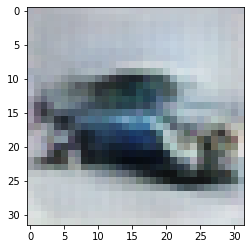


---------- Imagem gerada na epoch 117  ----------


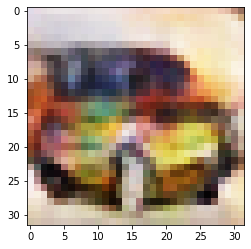


---------- Imagem gerada na epoch 118  ----------


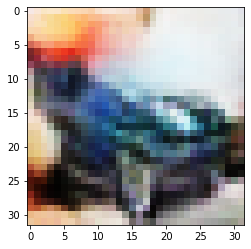


---------- Imagem gerada na epoch 119  ----------


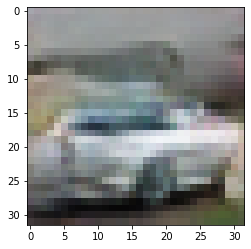


---------- Imagem gerada na epoch 120  ----------


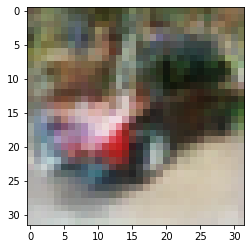


---------- Imagem gerada na epoch 121  ----------


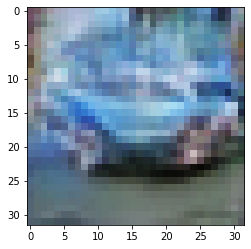


---------- Imagem gerada na epoch 122  ----------


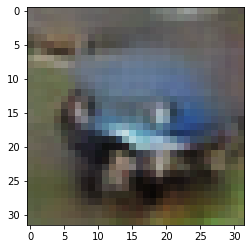


---------- Imagem gerada na epoch 123  ----------


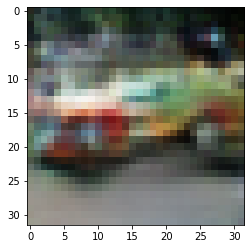


---------- Imagem gerada na epoch 124  ----------


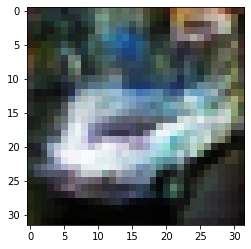


---------- Imagem gerada na epoch 125  ----------


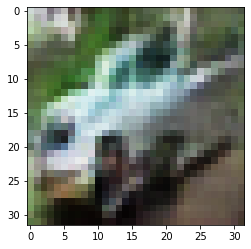


---------- Imagem gerada na epoch 126  ----------


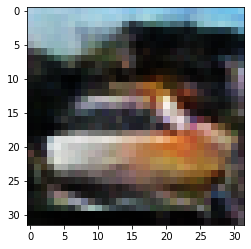


---------- Imagem gerada na epoch 127  ----------


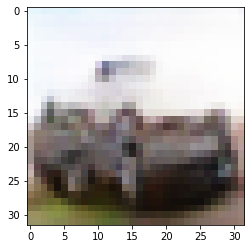


---------- Imagem gerada na epoch 128  ----------


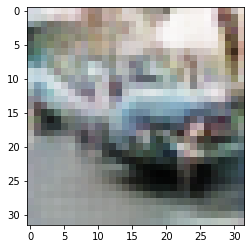


---------- Imagem gerada na epoch 129  ----------


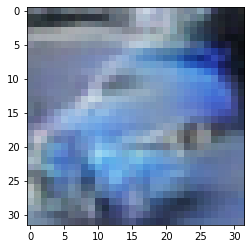


---------- Imagem gerada na epoch 130  ----------


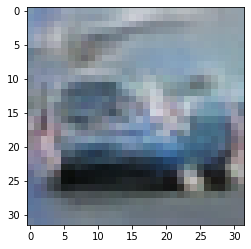


---------- Imagem gerada na epoch 131  ----------


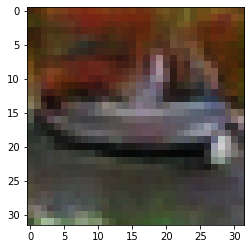


---------- Imagem gerada na epoch 132  ----------


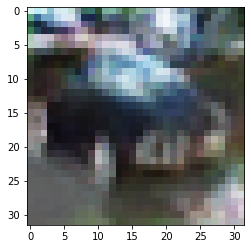


---------- Imagem gerada na epoch 133  ----------


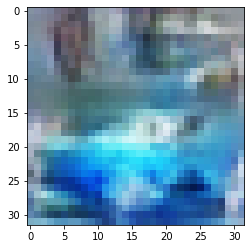


---------- Imagem gerada na epoch 134  ----------


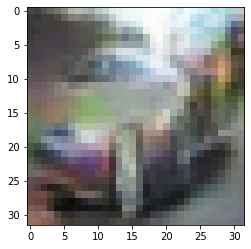


---------- Imagem gerada na epoch 135  ----------


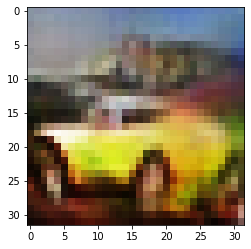


---------- Imagem gerada na epoch 136  ----------


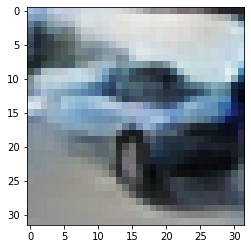


---------- Imagem gerada na epoch 137  ----------


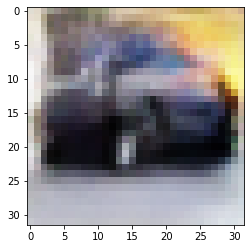


---------- Imagem gerada na epoch 138  ----------


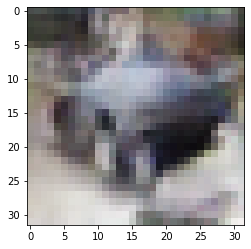


---------- Imagem gerada na epoch 139  ----------


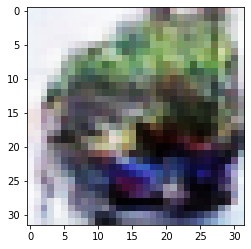


---------- Imagem gerada na epoch 140  ----------


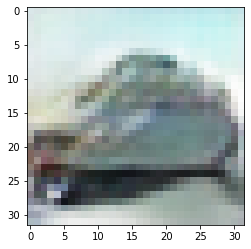


---------- Imagem gerada na epoch 141  ----------


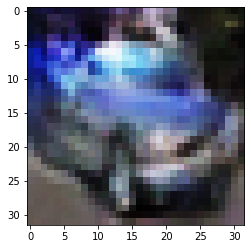


---------- Imagem gerada na epoch 142  ----------


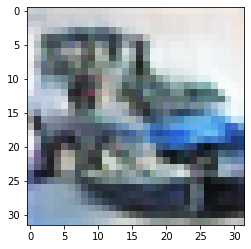


---------- Imagem gerada na epoch 143  ----------


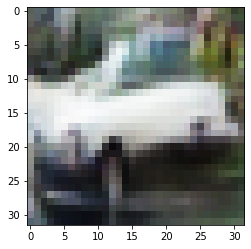


---------- Imagem gerada na epoch 144  ----------


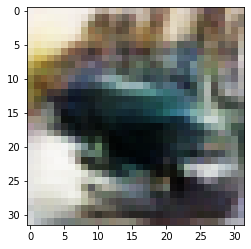


---------- Imagem gerada na epoch 145  ----------


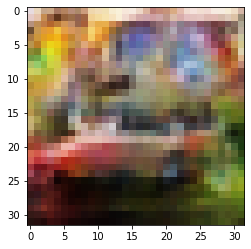


---------- Imagem gerada na epoch 146  ----------


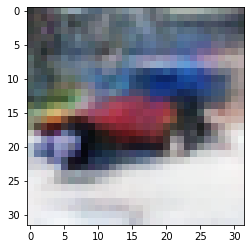


---------- Imagem gerada na epoch 147  ----------


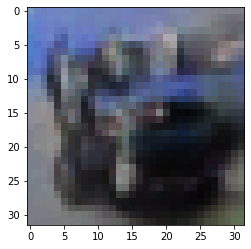


---------- Imagem gerada na epoch 148  ----------


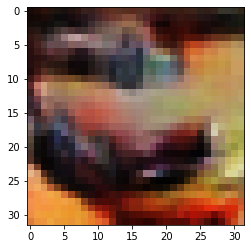


---------- Imagem gerada na epoch 149  ----------


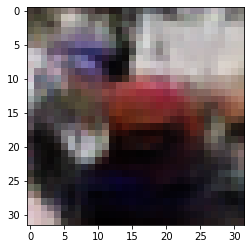


---------- Imagem gerada na epoch 150  ----------


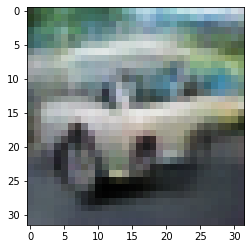


---------- Imagem gerada na epoch 151  ----------


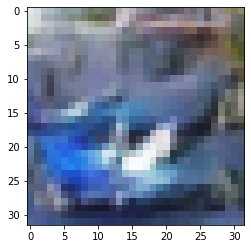


---------- Imagem gerada na epoch 152  ----------


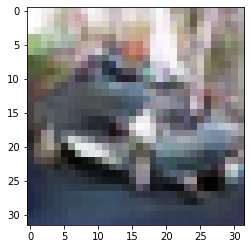


---------- Imagem gerada na epoch 153  ----------


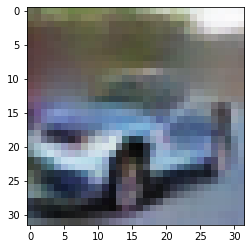


---------- Imagem gerada na epoch 154  ----------


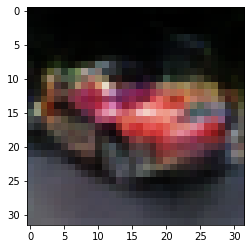


---------- Imagem gerada na epoch 155  ----------


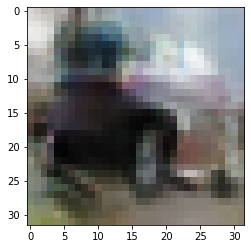


---------- Imagem gerada na epoch 156  ----------


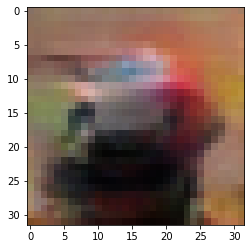


---------- Imagem gerada na epoch 157  ----------


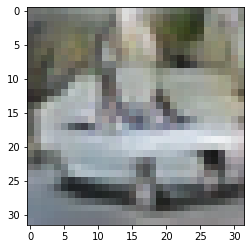


---------- Imagem gerada na epoch 158  ----------


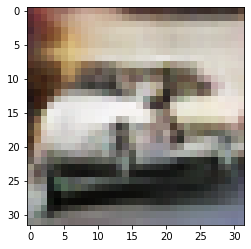


---------- Imagem gerada na epoch 159  ----------


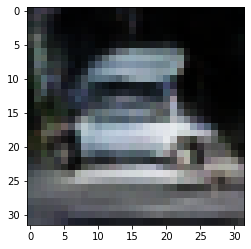


---------- Imagem gerada na epoch 160  ----------


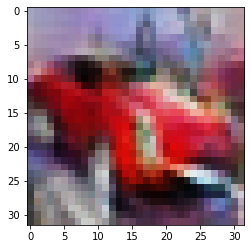


---------- Imagem gerada na epoch 161  ----------


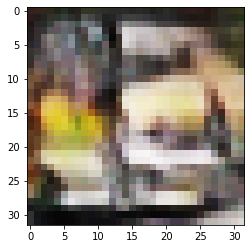


---------- Imagem gerada na epoch 162  ----------


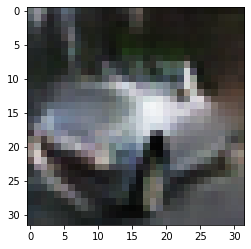


---------- Imagem gerada na epoch 163  ----------


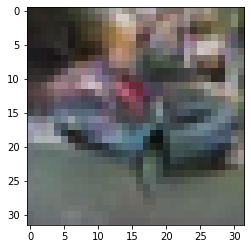


---------- Imagem gerada na epoch 164  ----------


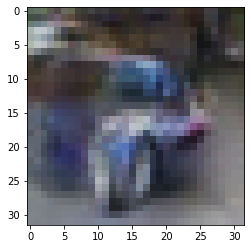


---------- Imagem gerada na epoch 165  ----------


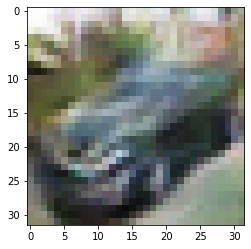


---------- Imagem gerada na epoch 166  ----------


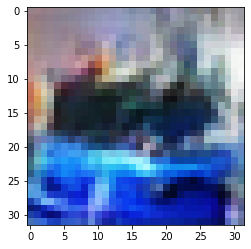


---------- Imagem gerada na epoch 167  ----------


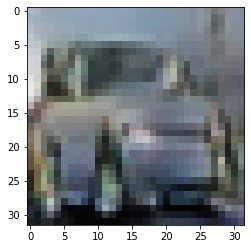


---------- Imagem gerada na epoch 168  ----------


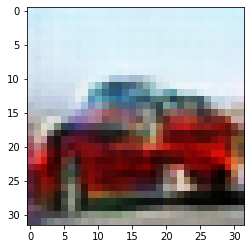


---------- Imagem gerada na epoch 169  ----------


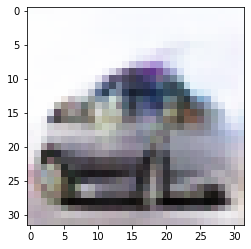


---------- Imagem gerada na epoch 170  ----------


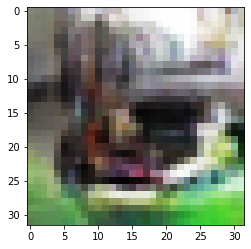


---------- Imagem gerada na epoch 171  ----------


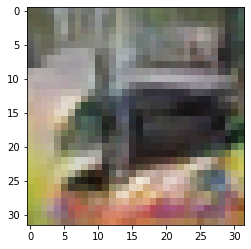


---------- Imagem gerada na epoch 172  ----------


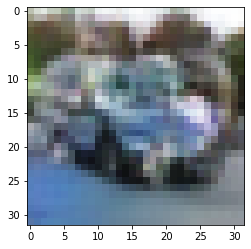


---------- Imagem gerada na epoch 173  ----------


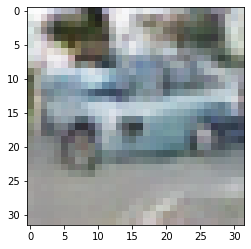


---------- Imagem gerada na epoch 174  ----------


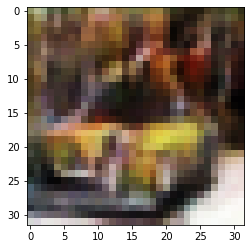


---------- Imagem gerada na epoch 175  ----------


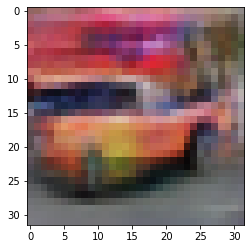


---------- Imagem gerada na epoch 176  ----------


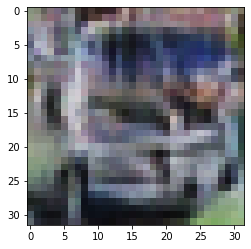


---------- Imagem gerada na epoch 177  ----------


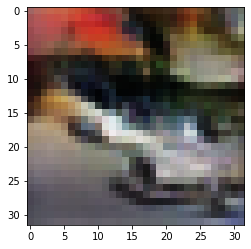


---------- Imagem gerada na epoch 178  ----------


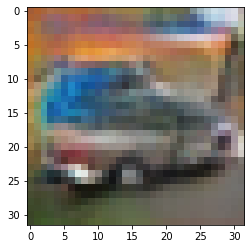


---------- Imagem gerada na epoch 179  ----------


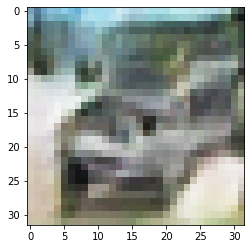


---------- Imagem gerada na epoch 180  ----------


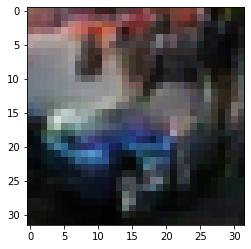


---------- Imagem gerada na epoch 181  ----------


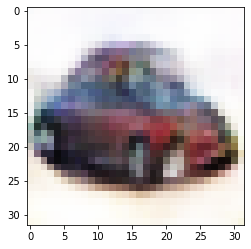


---------- Imagem gerada na epoch 182  ----------


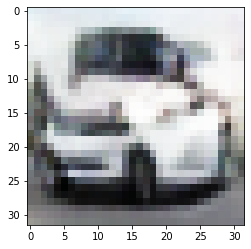


---------- Imagem gerada na epoch 183  ----------


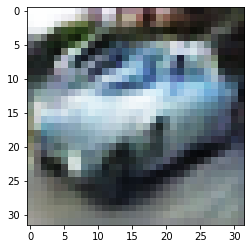


---------- Imagem gerada na epoch 184  ----------


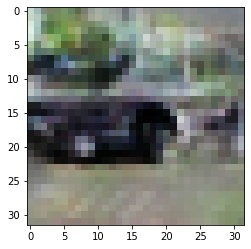


---------- Imagem gerada na epoch 185  ----------


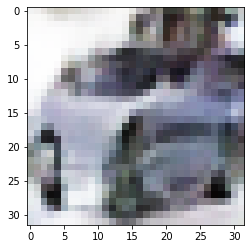


---------- Imagem gerada na epoch 186  ----------


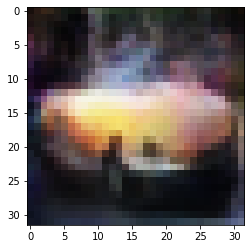


---------- Imagem gerada na epoch 187  ----------


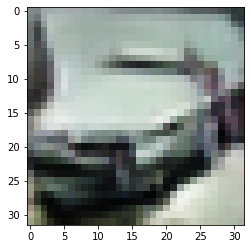


---------- Imagem gerada na epoch 188  ----------


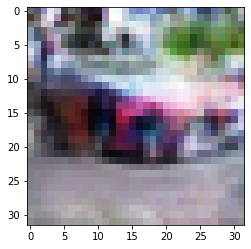


---------- Imagem gerada na epoch 189  ----------


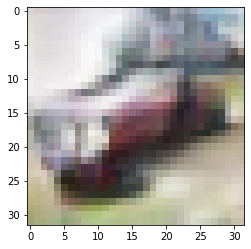


---------- Imagem gerada na epoch 190  ----------


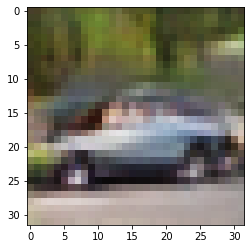


---------- Imagem gerada na epoch 191  ----------


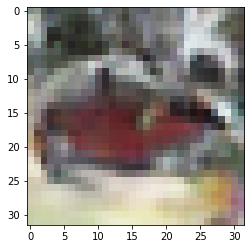


---------- Imagem gerada na epoch 192  ----------


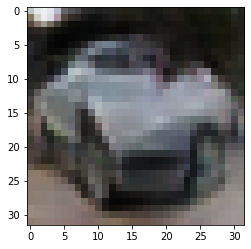


---------- Imagem gerada na epoch 193  ----------


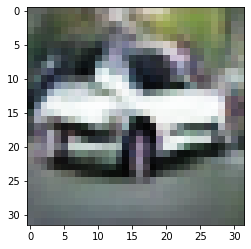


---------- Imagem gerada na epoch 194  ----------


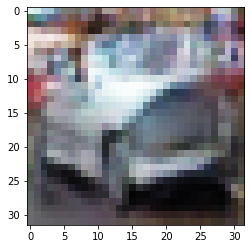


---------- Imagem gerada na epoch 195  ----------


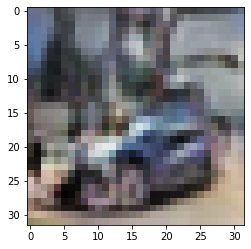


---------- Imagem gerada na epoch 196  ----------


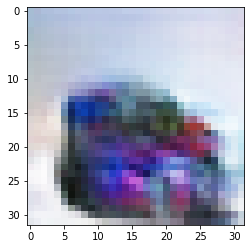


---------- Imagem gerada na epoch 197  ----------


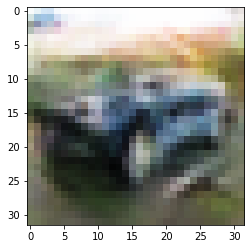


---------- Imagem gerada na epoch 198  ----------


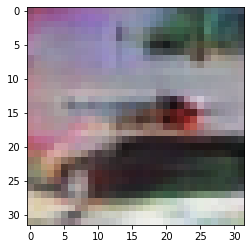


---------- Imagem gerada na epoch 199  ----------


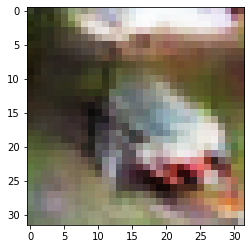


---------- Imagem gerada na epoch 200  ----------


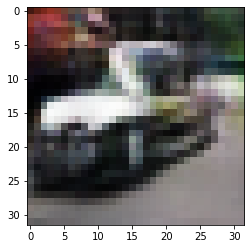


---------- Imagem gerada na epoch 201  ----------


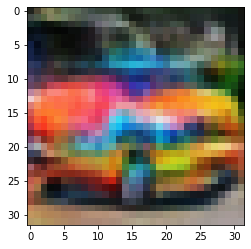


---------- Imagem gerada na epoch 202  ----------


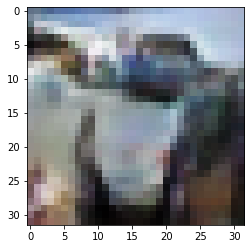


---------- Imagem gerada na epoch 203  ----------


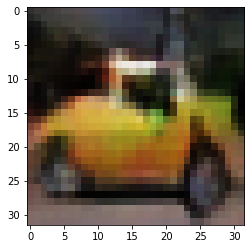


---------- Imagem gerada na epoch 204  ----------


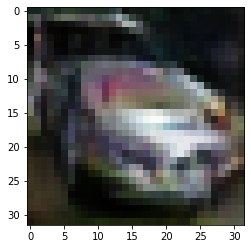


---------- Imagem gerada na epoch 205  ----------


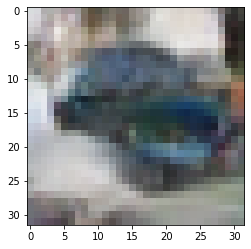


---------- Imagem gerada na epoch 206  ----------


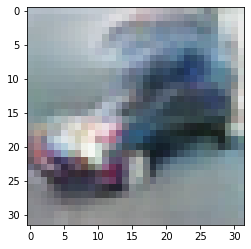


---------- Imagem gerada na epoch 207  ----------


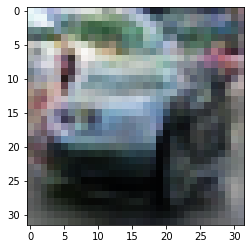


---------- Imagem gerada na epoch 208  ----------


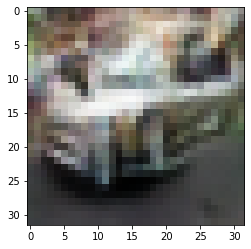


---------- Imagem gerada na epoch 209  ----------


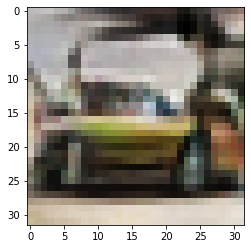


---------- Imagem gerada na epoch 210  ----------


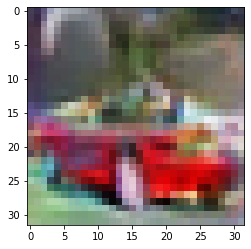


---------- Imagem gerada na epoch 211  ----------


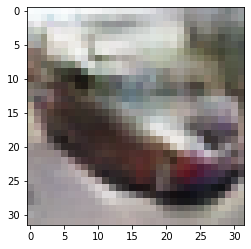


---------- Imagem gerada na epoch 212  ----------


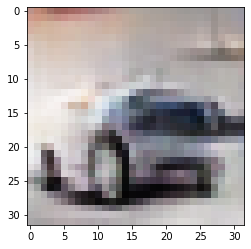


---------- Imagem gerada na epoch 213  ----------


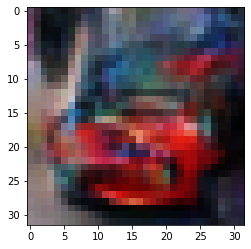


---------- Imagem gerada na epoch 214  ----------


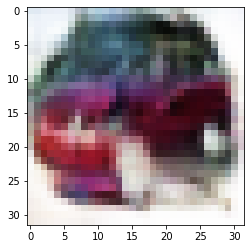


---------- Imagem gerada na epoch 215  ----------


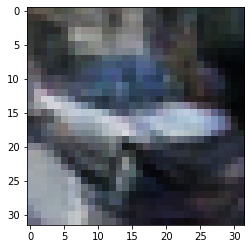


---------- Imagem gerada na epoch 216  ----------


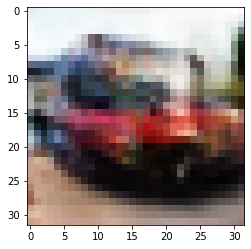


---------- Imagem gerada na epoch 217  ----------


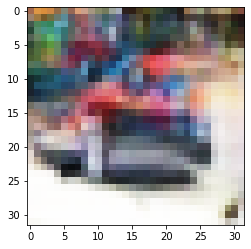


---------- Imagem gerada na epoch 218  ----------


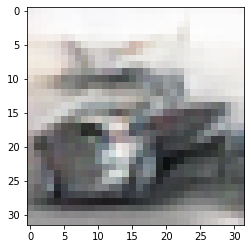


---------- Imagem gerada na epoch 219  ----------


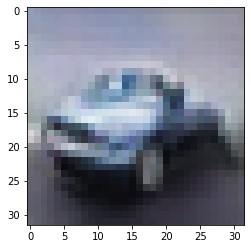


---------- Imagem gerada na epoch 220  ----------


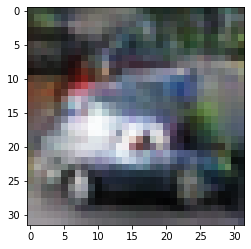


---------- Imagem gerada na epoch 221  ----------


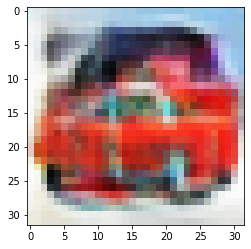


---------- Imagem gerada na epoch 222  ----------


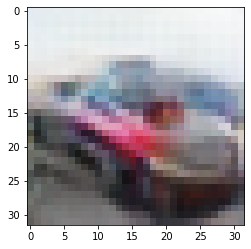


---------- Imagem gerada na epoch 223  ----------


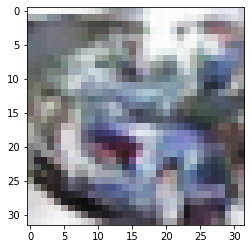


---------- Imagem gerada na epoch 224  ----------


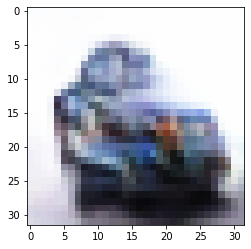


---------- Imagem gerada na epoch 225  ----------


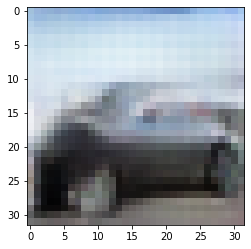


---------- Imagem gerada na epoch 226  ----------


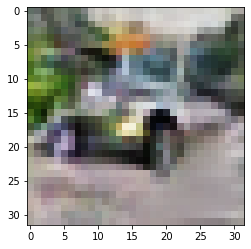


---------- Imagem gerada na epoch 227  ----------


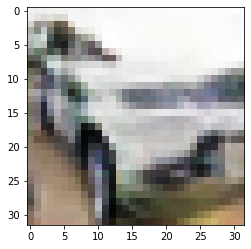


---------- Imagem gerada na epoch 228  ----------


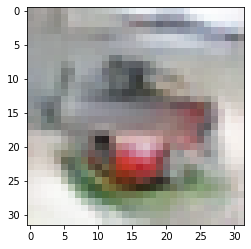


---------- Imagem gerada na epoch 229  ----------


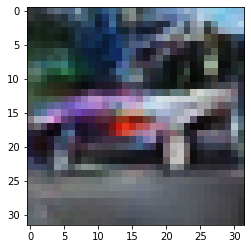


---------- Imagem gerada na epoch 230  ----------


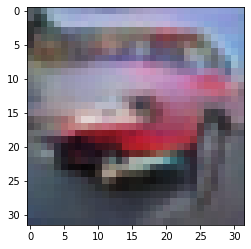


---------- Imagem gerada na epoch 231  ----------


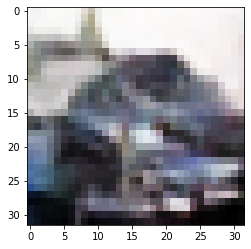


---------- Imagem gerada na epoch 232  ----------


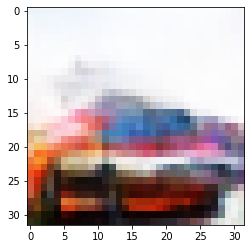


---------- Imagem gerada na epoch 233  ----------


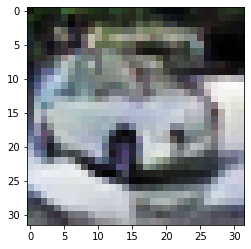


---------- Imagem gerada na epoch 234  ----------


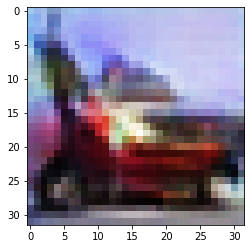


---------- Imagem gerada na epoch 235  ----------


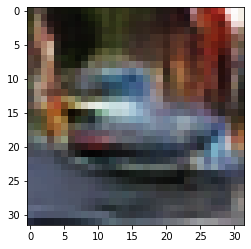


---------- Imagem gerada na epoch 236  ----------


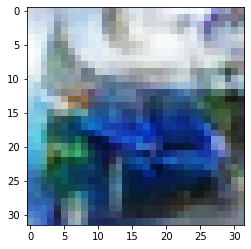


---------- Imagem gerada na epoch 237  ----------


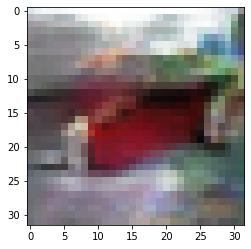


---------- Imagem gerada na epoch 238  ----------


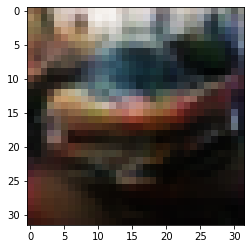


---------- Imagem gerada na epoch 239  ----------


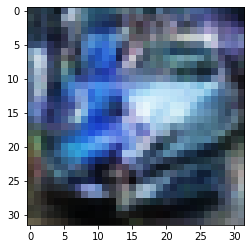


---------- Imagem gerada na epoch 240  ----------


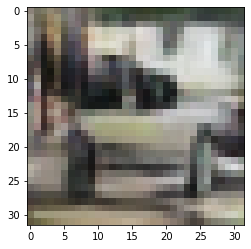


---------- Imagem gerada na epoch 241  ----------


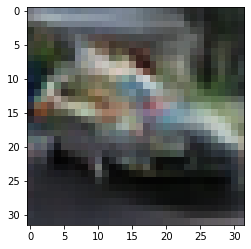


---------- Imagem gerada na epoch 242  ----------


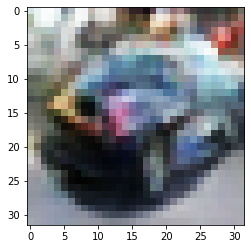


---------- Imagem gerada na epoch 243  ----------


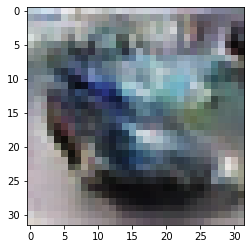


---------- Imagem gerada na epoch 244  ----------


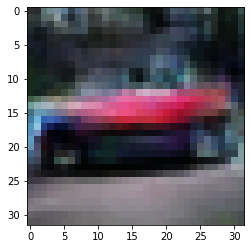


---------- Imagem gerada na epoch 245  ----------


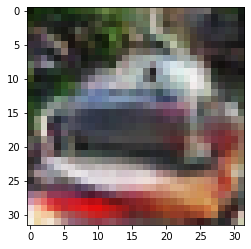


---------- Imagem gerada na epoch 246  ----------


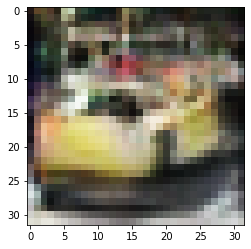


---------- Imagem gerada na epoch 247  ----------


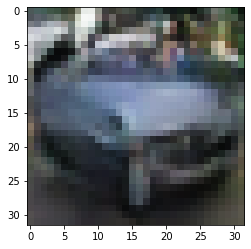


---------- Imagem gerada na epoch 248  ----------


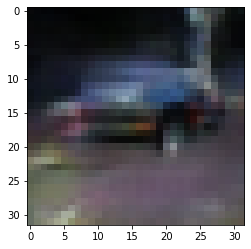


---------- Imagem gerada na epoch 249  ----------


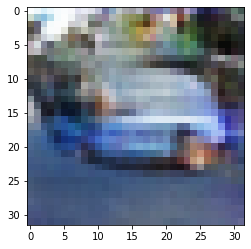


---------- Imagem gerada na epoch 250  ----------


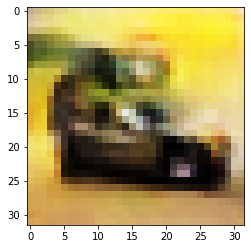


---------- Imagem gerada na epoch 251  ----------


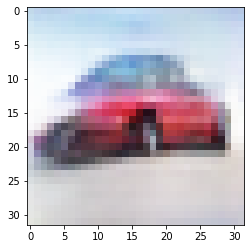


---------- Imagem gerada na epoch 252  ----------


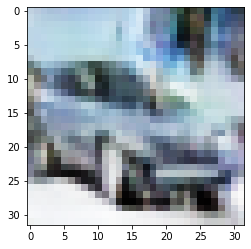


---------- Imagem gerada na epoch 253  ----------


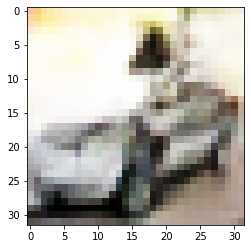


---------- Imagem gerada na epoch 254  ----------


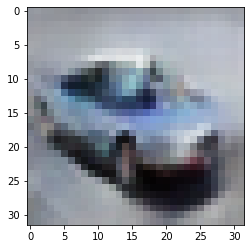


---------- Imagem gerada na epoch 255  ----------


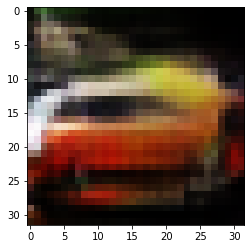


---------- Imagem gerada na epoch 256  ----------


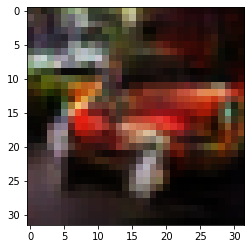


---------- Imagem gerada na epoch 257  ----------


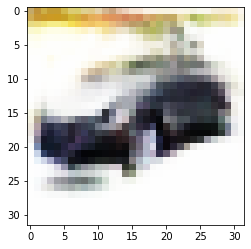


---------- Imagem gerada na epoch 258  ----------


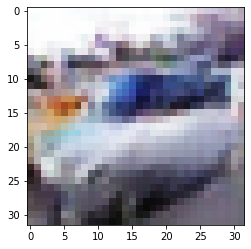


---------- Imagem gerada na epoch 259  ----------


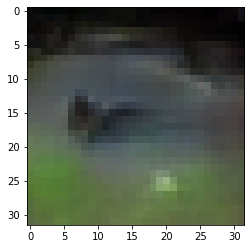


---------- Imagem gerada na epoch 260  ----------


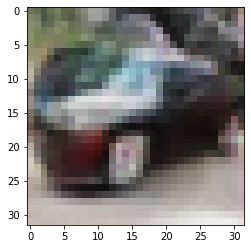


---------- Imagem gerada na epoch 261  ----------


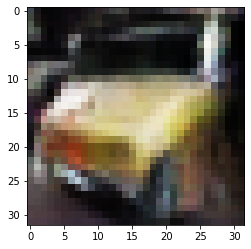


---------- Imagem gerada na epoch 262  ----------


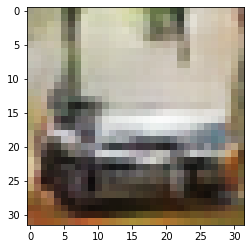


---------- Imagem gerada na epoch 263  ----------


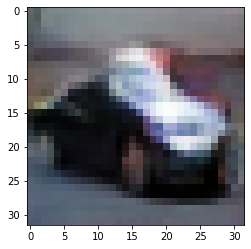


---------- Imagem gerada na epoch 264  ----------


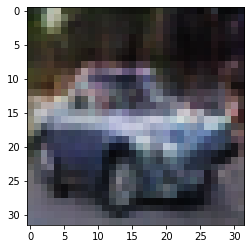


---------- Imagem gerada na epoch 265  ----------


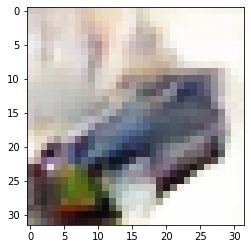


---------- Imagem gerada na epoch 266  ----------


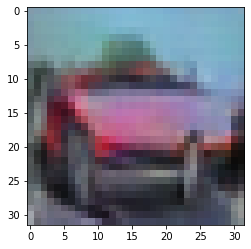


---------- Imagem gerada na epoch 267  ----------


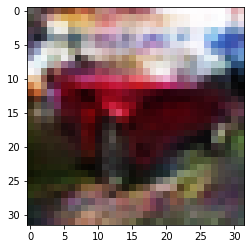


---------- Imagem gerada na epoch 268  ----------


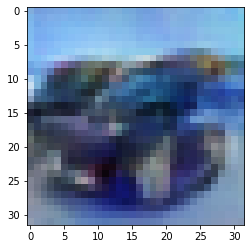


---------- Imagem gerada na epoch 269  ----------


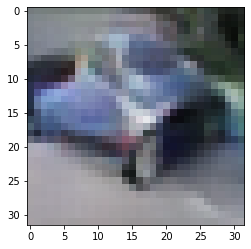


---------- Imagem gerada na epoch 270  ----------


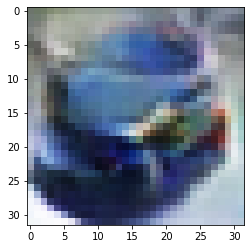


---------- Imagem gerada na epoch 271  ----------


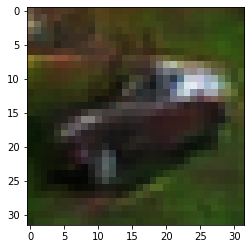


---------- Imagem gerada na epoch 272  ----------


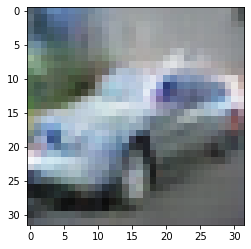


---------- Imagem gerada na epoch 273  ----------


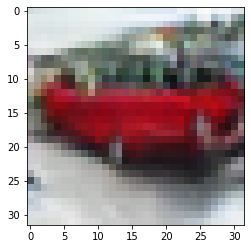


---------- Imagem gerada na epoch 274  ----------


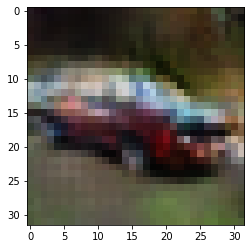


---------- Imagem gerada na epoch 275  ----------


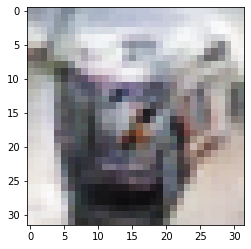


---------- Imagem gerada na epoch 276  ----------


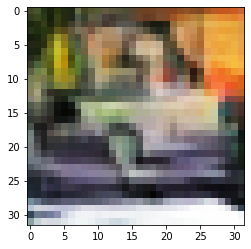


---------- Imagem gerada na epoch 277  ----------


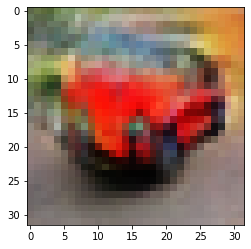


---------- Imagem gerada na epoch 278  ----------


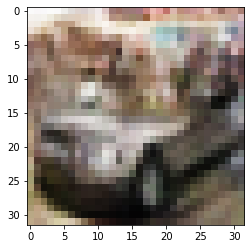


---------- Imagem gerada na epoch 279  ----------


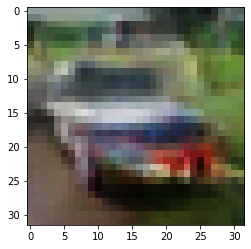


---------- Imagem gerada na epoch 280  ----------


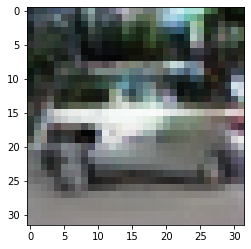


---------- Imagem gerada na epoch 281  ----------


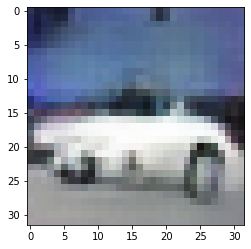


---------- Imagem gerada na epoch 282  ----------


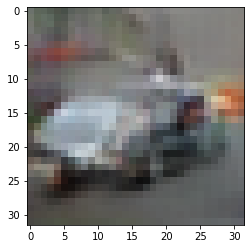


---------- Imagem gerada na epoch 283  ----------


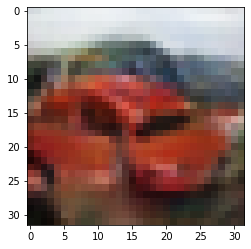


---------- Imagem gerada na epoch 284  ----------


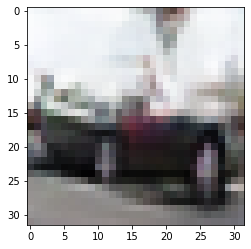


---------- Imagem gerada na epoch 285  ----------


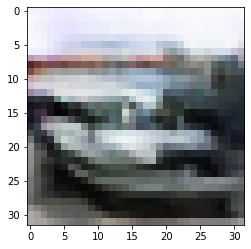


---------- Imagem gerada na epoch 286  ----------


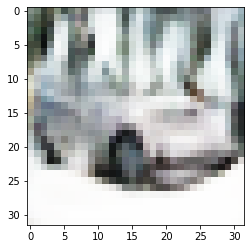


---------- Imagem gerada na epoch 287  ----------


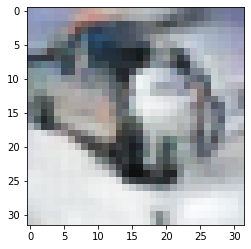


---------- Imagem gerada na epoch 288  ----------


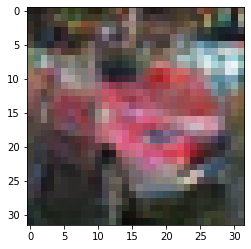


---------- Imagem gerada na epoch 289  ----------


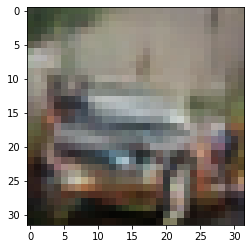


---------- Imagem gerada na epoch 290  ----------


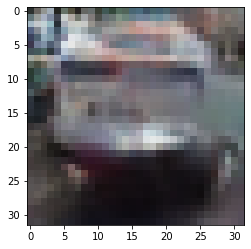


---------- Imagem gerada na epoch 291  ----------


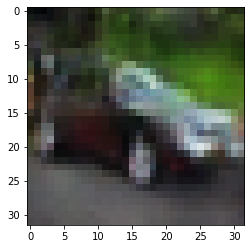


---------- Imagem gerada na epoch 292  ----------


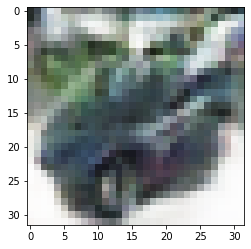


---------- Imagem gerada na epoch 293  ----------


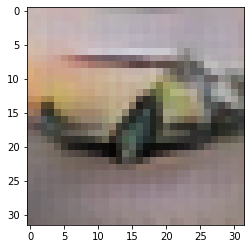


---------- Imagem gerada na epoch 294  ----------


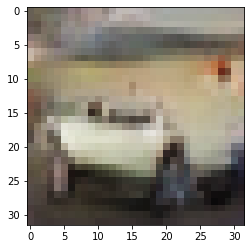


---------- Imagem gerada na epoch 295  ----------


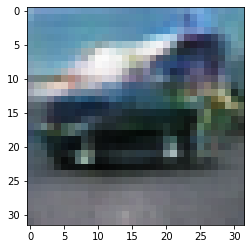


---------- Imagem gerada na epoch 296  ----------


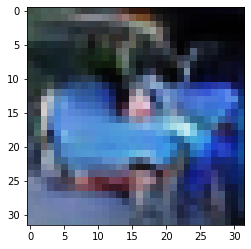


---------- Imagem gerada na epoch 297  ----------


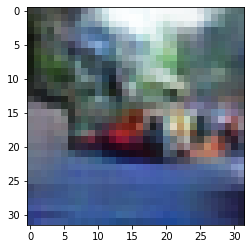


---------- Imagem gerada na epoch 298  ----------


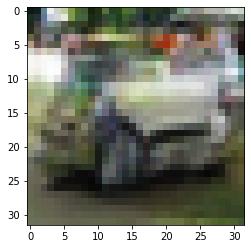


---------- Imagem gerada na epoch 299  ----------


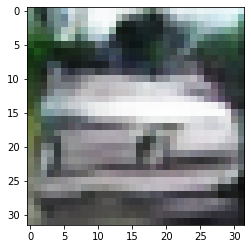


---------- Imagem gerada na epoch 300  ----------


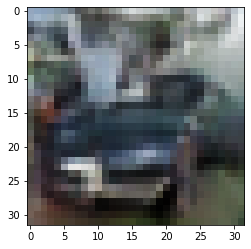


---------- Imagem gerada na epoch 301  ----------


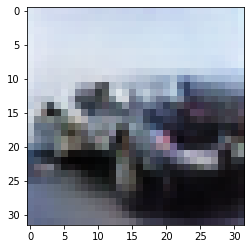


---------- Imagem gerada na epoch 302  ----------


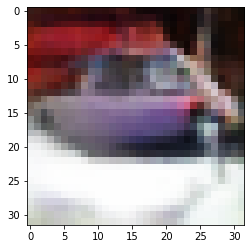


---------- Imagem gerada na epoch 303  ----------


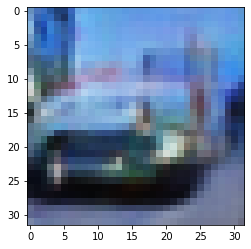


---------- Imagem gerada na epoch 304  ----------


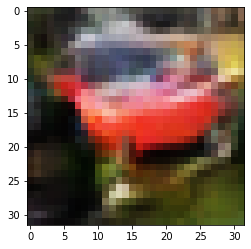


---------- Imagem gerada na epoch 305  ----------


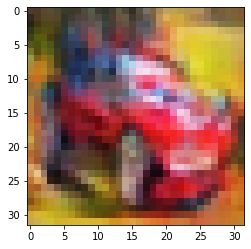


---------- Imagem gerada na epoch 306  ----------


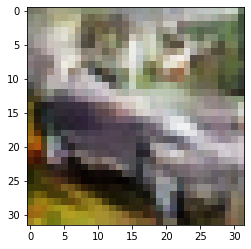


---------- Imagem gerada na epoch 307  ----------


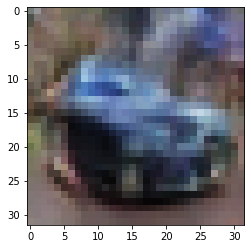


---------- Imagem gerada na epoch 308  ----------


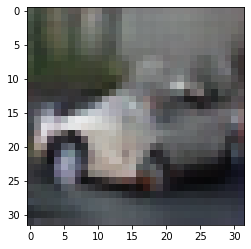


---------- Imagem gerada na epoch 309  ----------


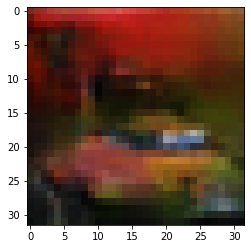


---------- Imagem gerada na epoch 310  ----------


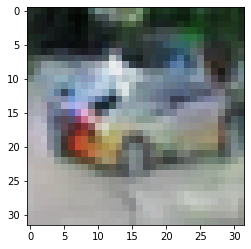


---------- Imagem gerada na epoch 311  ----------


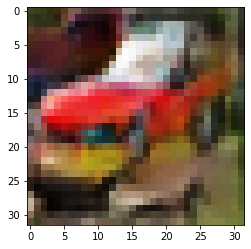


---------- Imagem gerada na epoch 312  ----------


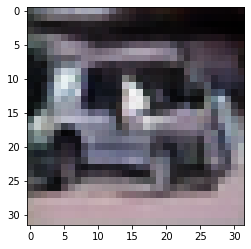


---------- Imagem gerada na epoch 313  ----------


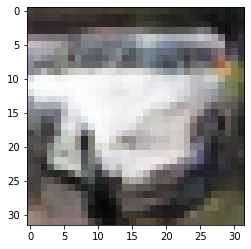


---------- Imagem gerada na epoch 314  ----------


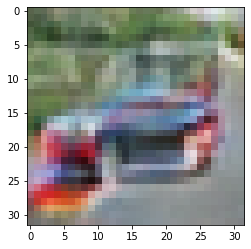


---------- Imagem gerada na epoch 315  ----------


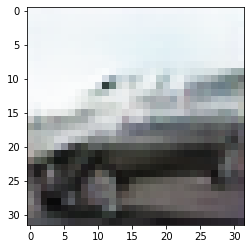


---------- Imagem gerada na epoch 316  ----------


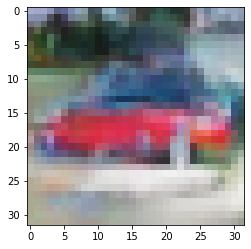


---------- Imagem gerada na epoch 317  ----------


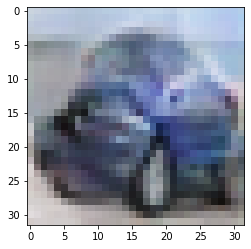


---------- Imagem gerada na epoch 318  ----------


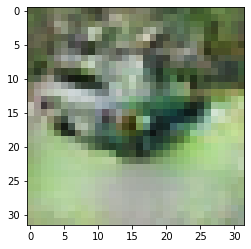


---------- Imagem gerada na epoch 319  ----------


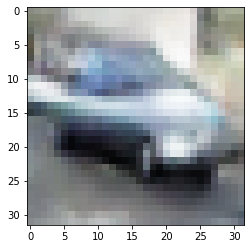


---------- Imagem gerada na epoch 320  ----------


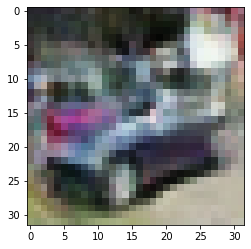


---------- Imagem gerada na epoch 321  ----------


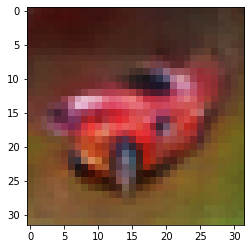


---------- Imagem gerada na epoch 322  ----------


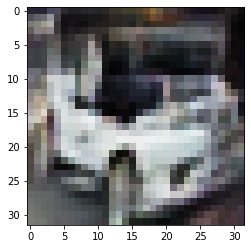


---------- Imagem gerada na epoch 323  ----------


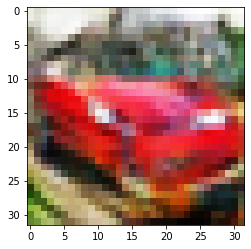


---------- Imagem gerada na epoch 324  ----------


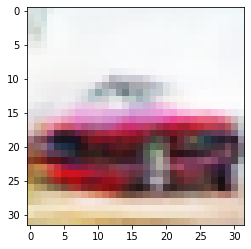


---------- Imagem gerada na epoch 325  ----------


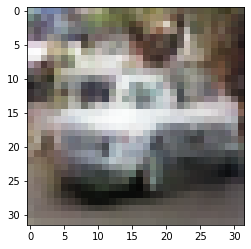


---------- Imagem gerada na epoch 326  ----------


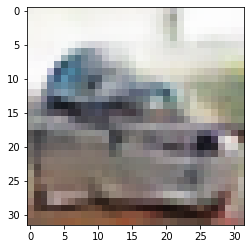


---------- Imagem gerada na epoch 327  ----------


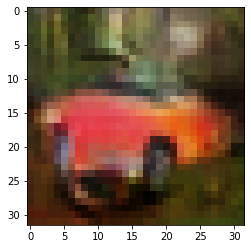


---------- Imagem gerada na epoch 328  ----------


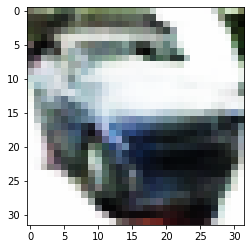


---------- Imagem gerada na epoch 329  ----------


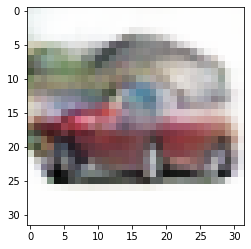


---------- Imagem gerada na epoch 330  ----------


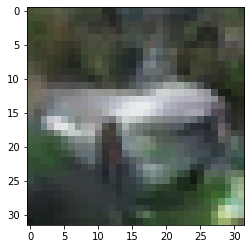


---------- Imagem gerada na epoch 331  ----------


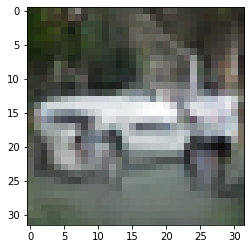


---------- Imagem gerada na epoch 332  ----------


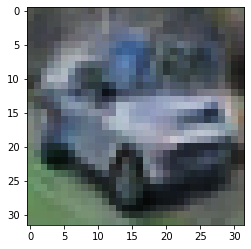


---------- Imagem gerada na epoch 333  ----------


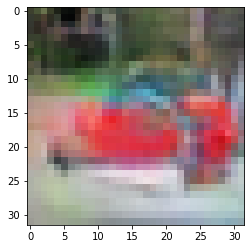


---------- Imagem gerada na epoch 334  ----------


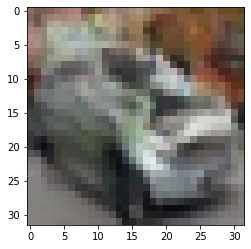


---------- Imagem gerada na epoch 335  ----------


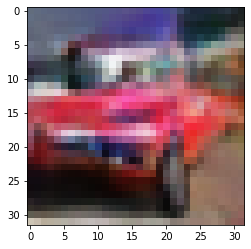


---------- Imagem gerada na epoch 336  ----------


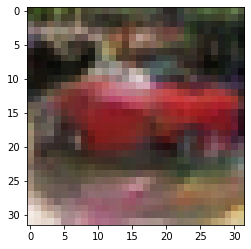


---------- Imagem gerada na epoch 337  ----------


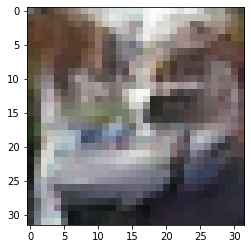


---------- Imagem gerada na epoch 338  ----------


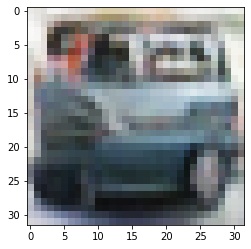


---------- Imagem gerada na epoch 339  ----------


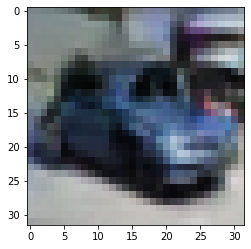


---------- Imagem gerada na epoch 340  ----------


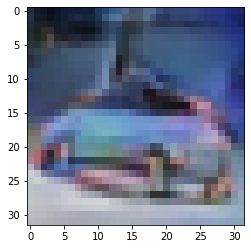


---------- Imagem gerada na epoch 341  ----------


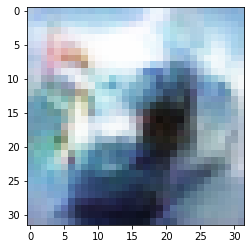


---------- Imagem gerada na epoch 342  ----------


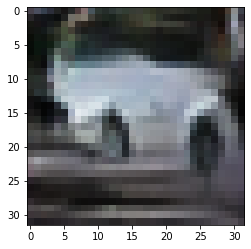


---------- Imagem gerada na epoch 343  ----------


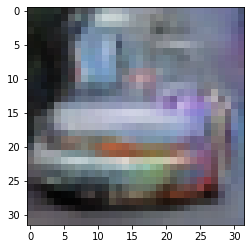


---------- Imagem gerada na epoch 344  ----------


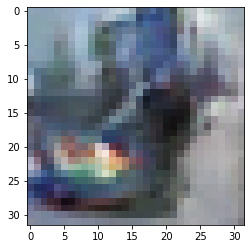


---------- Imagem gerada na epoch 345  ----------


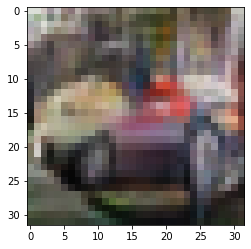


---------- Imagem gerada na epoch 346  ----------


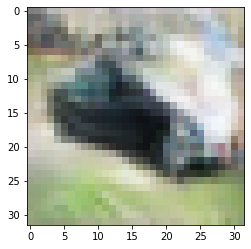


---------- Imagem gerada na epoch 347  ----------


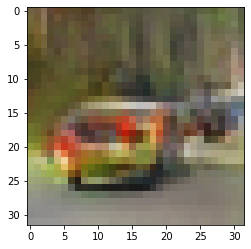


---------- Imagem gerada na epoch 348  ----------


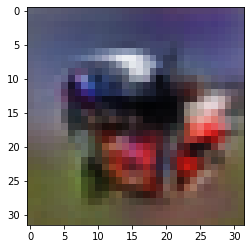


---------- Imagem gerada na epoch 349  ----------


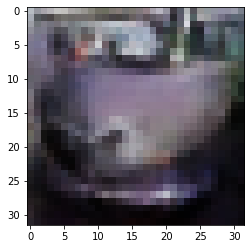


---------- Imagem gerada na epoch 350  ----------


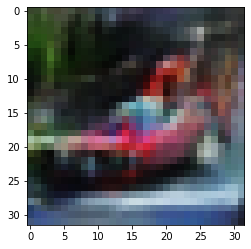


---------- Imagem gerada na epoch 351  ----------


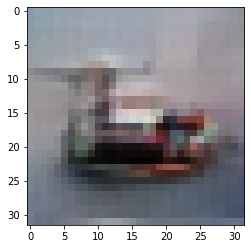


---------- Imagem gerada na epoch 352  ----------


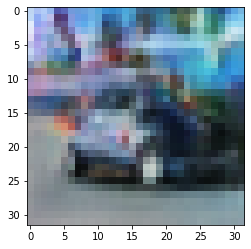


---------- Imagem gerada na epoch 353  ----------


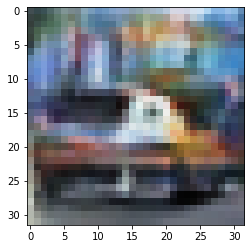


---------- Imagem gerada na epoch 354  ----------


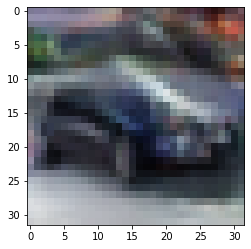


---------- Imagem gerada na epoch 355  ----------


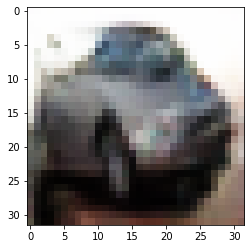


---------- Imagem gerada na epoch 356  ----------


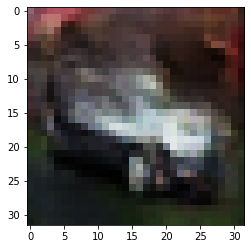


---------- Imagem gerada na epoch 357  ----------


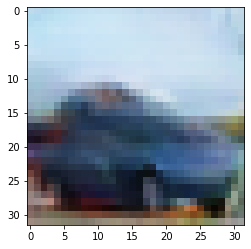


---------- Imagem gerada na epoch 358  ----------


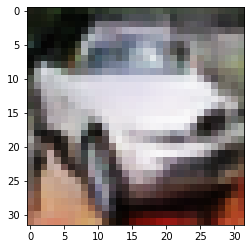


---------- Imagem gerada na epoch 359  ----------


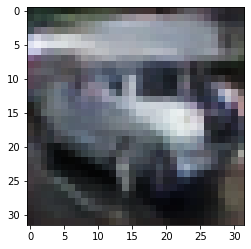


---------- Imagem gerada na epoch 360  ----------


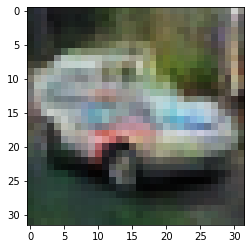


---------- Imagem gerada na epoch 361  ----------


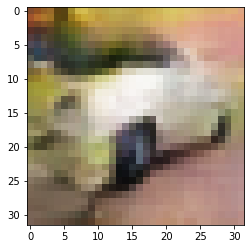


---------- Imagem gerada na epoch 362  ----------


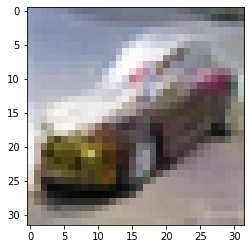


---------- Imagem gerada na epoch 363  ----------


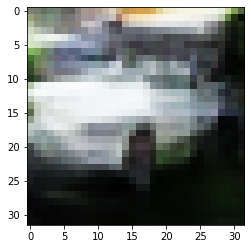


---------- Imagem gerada na epoch 364  ----------


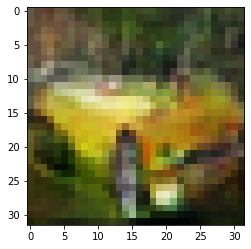


---------- Imagem gerada na epoch 365  ----------


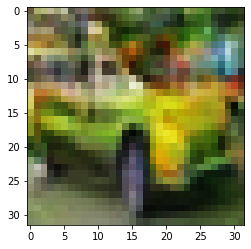


---------- Imagem gerada na epoch 366  ----------


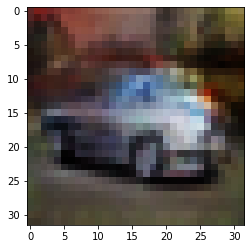


---------- Imagem gerada na epoch 367  ----------


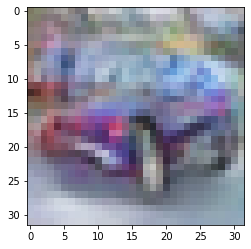


---------- Imagem gerada na epoch 368  ----------


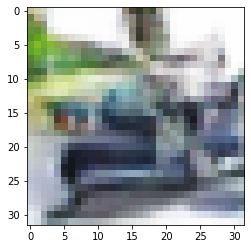


---------- Imagem gerada na epoch 369  ----------


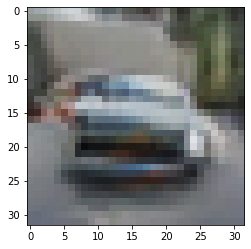


---------- Imagem gerada na epoch 370  ----------


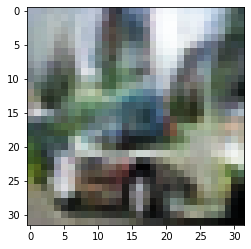


---------- Imagem gerada na epoch 371  ----------


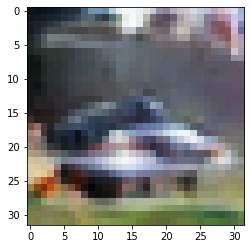


---------- Imagem gerada na epoch 372  ----------


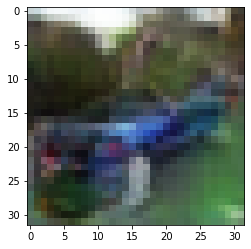


---------- Imagem gerada na epoch 373  ----------


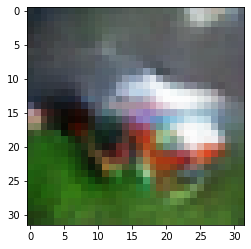


---------- Imagem gerada na epoch 374  ----------


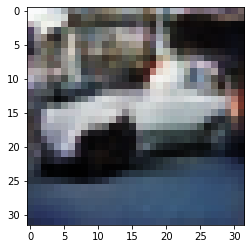


---------- Imagem gerada na epoch 375  ----------


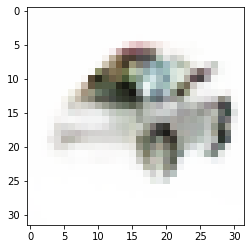


---------- Imagem gerada na epoch 376  ----------


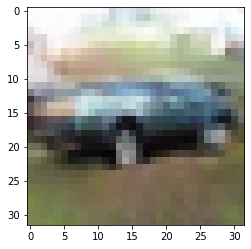


---------- Imagem gerada na epoch 377  ----------


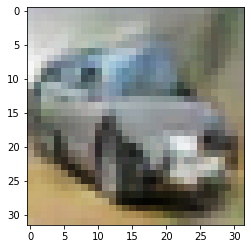


---------- Imagem gerada na epoch 378  ----------


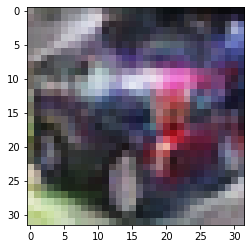


---------- Imagem gerada na epoch 379  ----------


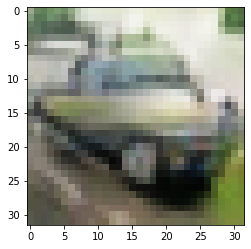


---------- Imagem gerada na epoch 380  ----------


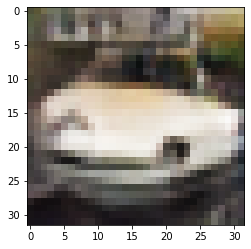


---------- Imagem gerada na epoch 381  ----------


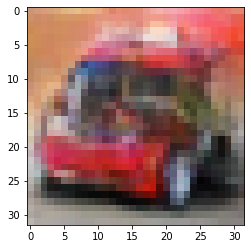


---------- Imagem gerada na epoch 382  ----------


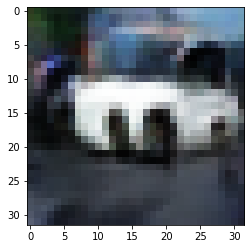


---------- Imagem gerada na epoch 383  ----------


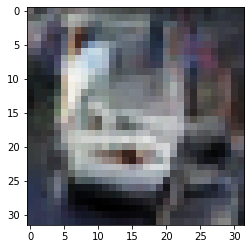


---------- Imagem gerada na epoch 384  ----------


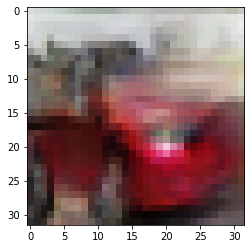


---------- Imagem gerada na epoch 385  ----------


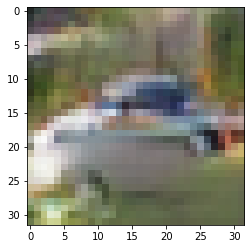


---------- Imagem gerada na epoch 386  ----------


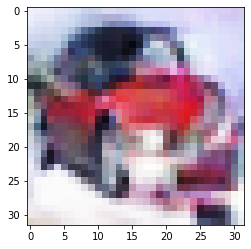


---------- Imagem gerada na epoch 387  ----------


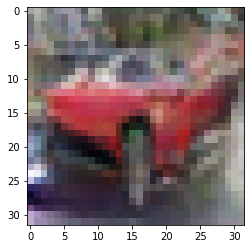


---------- Imagem gerada na epoch 388  ----------


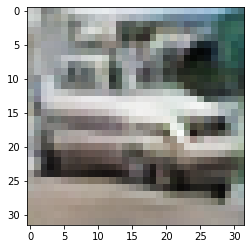


---------- Imagem gerada na epoch 389  ----------


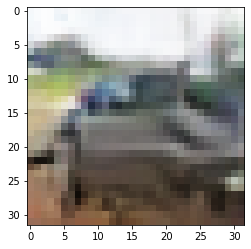


---------- Imagem gerada na epoch 390  ----------


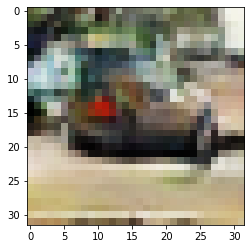


---------- Imagem gerada na epoch 391  ----------


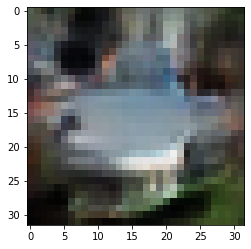


---------- Imagem gerada na epoch 392  ----------


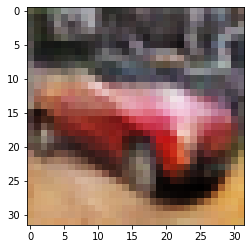


---------- Imagem gerada na epoch 393  ----------


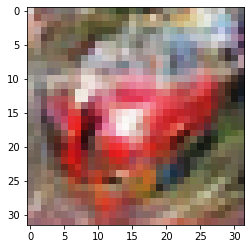


---------- Imagem gerada na epoch 394  ----------


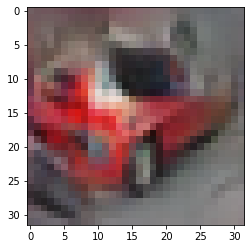


---------- Imagem gerada na epoch 395  ----------


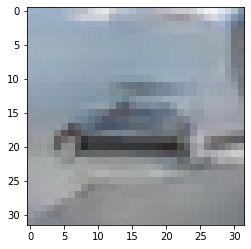


---------- Imagem gerada na epoch 396  ----------


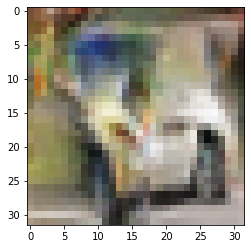


---------- Imagem gerada na epoch 397  ----------


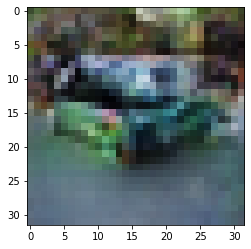


---------- Imagem gerada na epoch 398  ----------


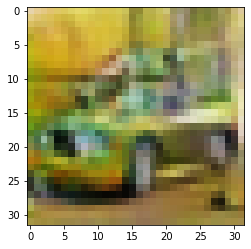


---------- Imagem gerada na epoch 399  ----------


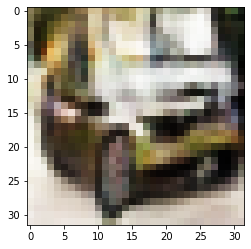


---------- Imagem gerada na epoch 400  ----------


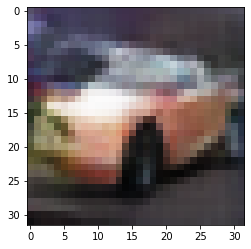


---------- Imagem gerada na epoch 401  ----------


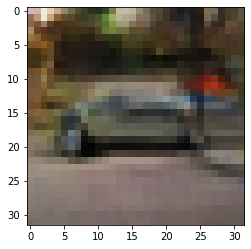


---------- Imagem gerada na epoch 402  ----------


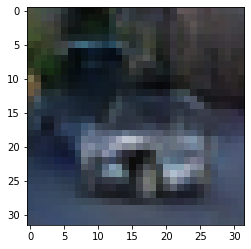


---------- Imagem gerada na epoch 403  ----------


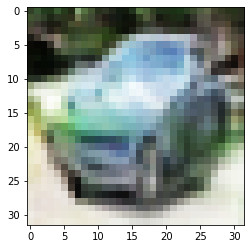


---------- Imagem gerada na epoch 404  ----------


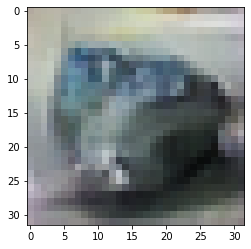


---------- Imagem gerada na epoch 405  ----------


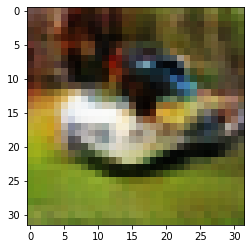


---------- Imagem gerada na epoch 406  ----------


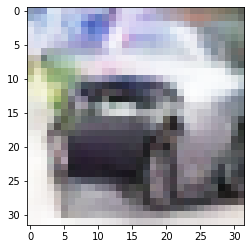


---------- Imagem gerada na epoch 407  ----------


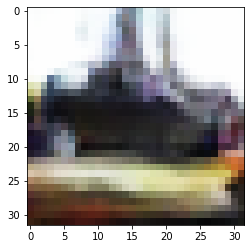


---------- Imagem gerada na epoch 408  ----------


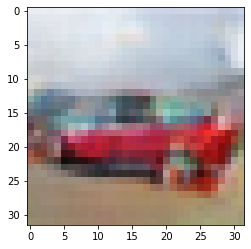


---------- Imagem gerada na epoch 409  ----------


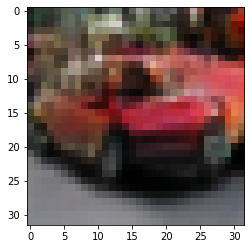


---------- Imagem gerada na epoch 410  ----------


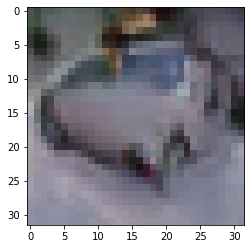


---------- Imagem gerada na epoch 411  ----------


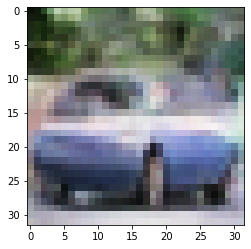


---------- Imagem gerada na epoch 412  ----------


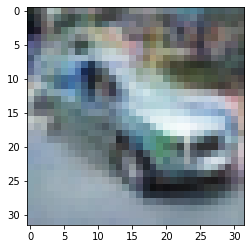


---------- Imagem gerada na epoch 413  ----------


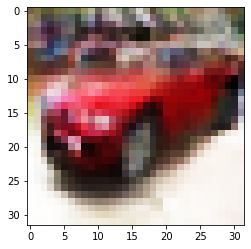


---------- Imagem gerada na epoch 414  ----------


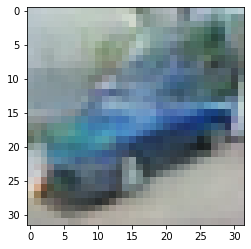


---------- Imagem gerada na epoch 415  ----------


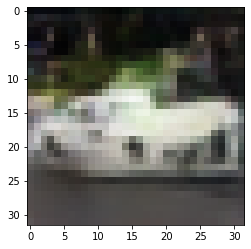


---------- Imagem gerada na epoch 416  ----------


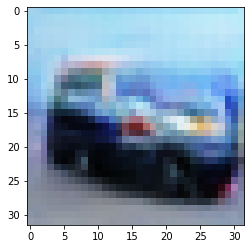


---------- Imagem gerada na epoch 417  ----------


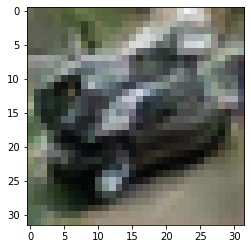


---------- Imagem gerada na epoch 418  ----------


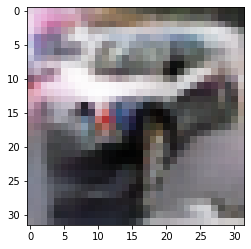


---------- Imagem gerada na epoch 419  ----------


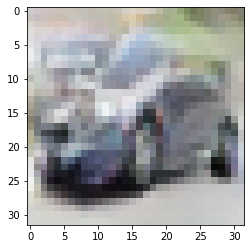


---------- Imagem gerada na epoch 420  ----------


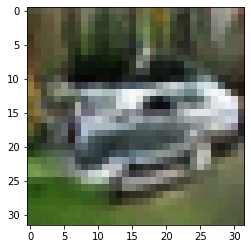


---------- Imagem gerada na epoch 421  ----------


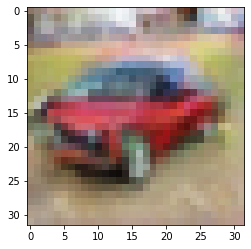


---------- Imagem gerada na epoch 422  ----------


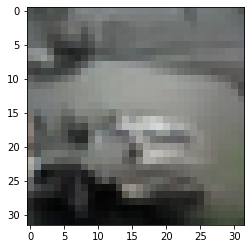


---------- Imagem gerada na epoch 423  ----------


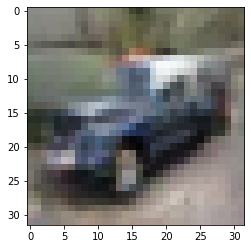


---------- Imagem gerada na epoch 424  ----------


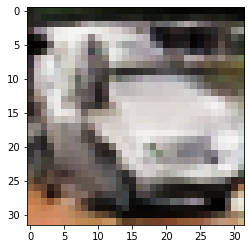


---------- Imagem gerada na epoch 425  ----------


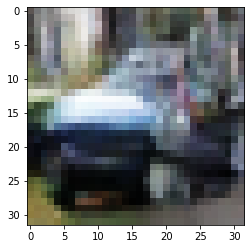


---------- Imagem gerada na epoch 426  ----------


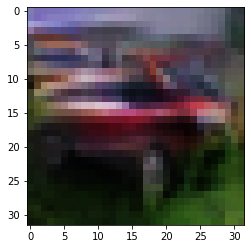


---------- Imagem gerada na epoch 427  ----------


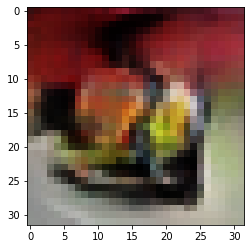


---------- Imagem gerada na epoch 428  ----------


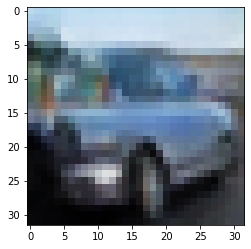


---------- Imagem gerada na epoch 429  ----------


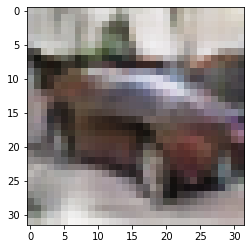


---------- Imagem gerada na epoch 430  ----------


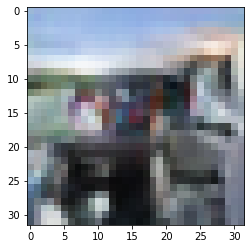


---------- Imagem gerada na epoch 431  ----------


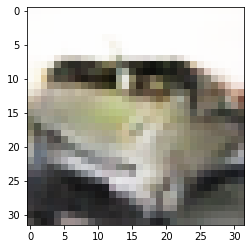


---------- Imagem gerada na epoch 432  ----------


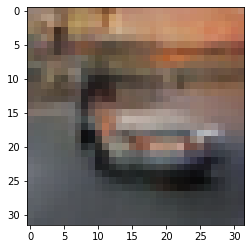


---------- Imagem gerada na epoch 433  ----------


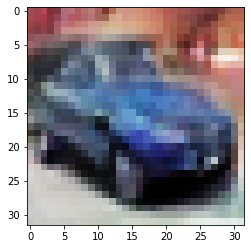


---------- Imagem gerada na epoch 434  ----------


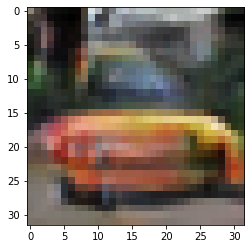


---------- Imagem gerada na epoch 435  ----------


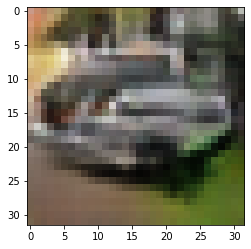


---------- Imagem gerada na epoch 436  ----------


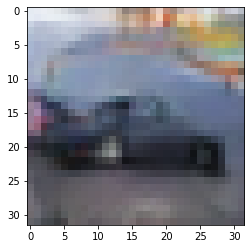


---------- Imagem gerada na epoch 437  ----------


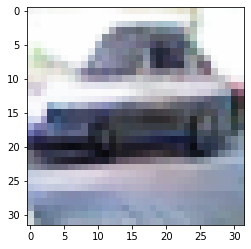


---------- Imagem gerada na epoch 438  ----------


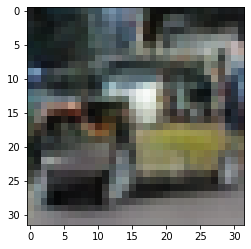


---------- Imagem gerada na epoch 439  ----------


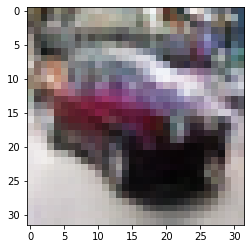


---------- Imagem gerada na epoch 440  ----------


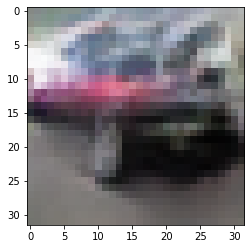


---------- Imagem gerada na epoch 441  ----------


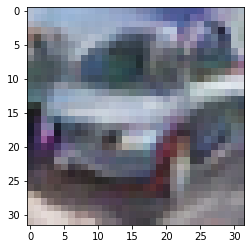


---------- Imagem gerada na epoch 442  ----------


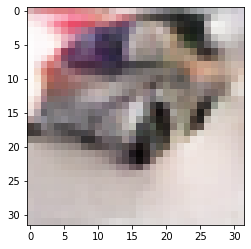


---------- Imagem gerada na epoch 443  ----------


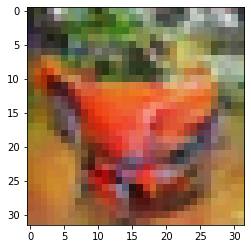


---------- Imagem gerada na epoch 444  ----------


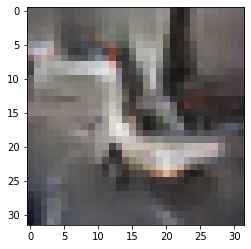


---------- Imagem gerada na epoch 445  ----------


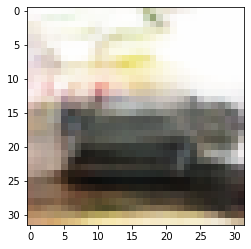


---------- Imagem gerada na epoch 446  ----------


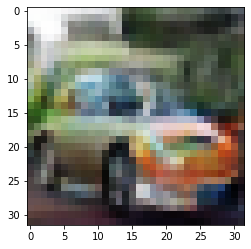


---------- Imagem gerada na epoch 447  ----------


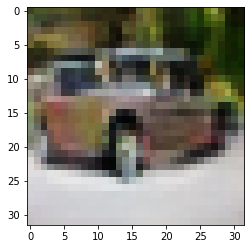


---------- Imagem gerada na epoch 448  ----------


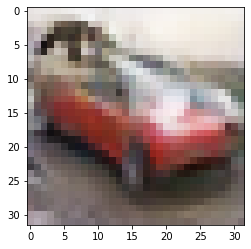


---------- Imagem gerada na epoch 449  ----------


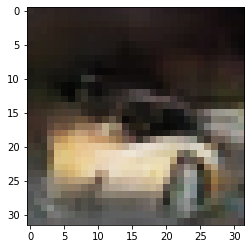


---------- Imagem gerada na epoch 450  ----------


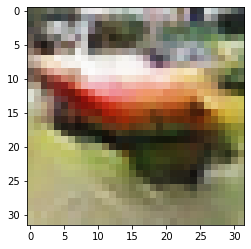


---------- Imagem gerada na epoch 451  ----------


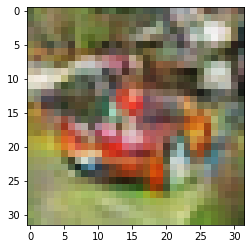


---------- Imagem gerada na epoch 452  ----------


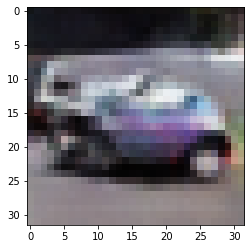


---------- Imagem gerada na epoch 453  ----------


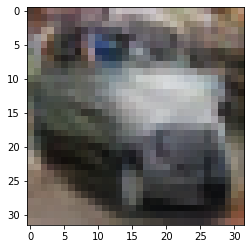


---------- Imagem gerada na epoch 454  ----------


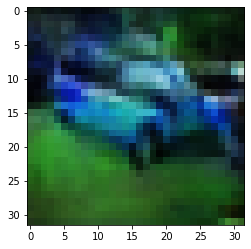


---------- Imagem gerada na epoch 455  ----------


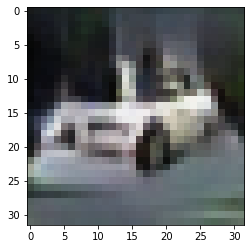


---------- Imagem gerada na epoch 456  ----------


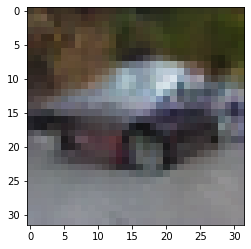


---------- Imagem gerada na epoch 457  ----------


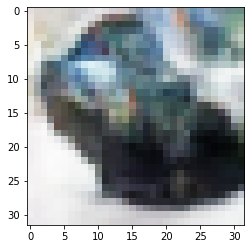


---------- Imagem gerada na epoch 458  ----------


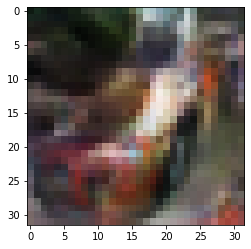


---------- Imagem gerada na epoch 459  ----------


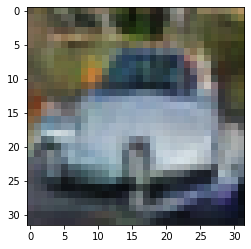


---------- Imagem gerada na epoch 460  ----------


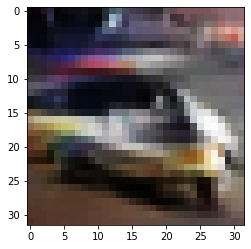


---------- Imagem gerada na epoch 461  ----------


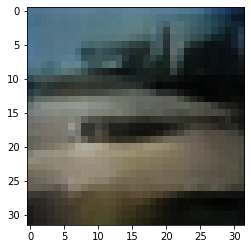


---------- Imagem gerada na epoch 462  ----------


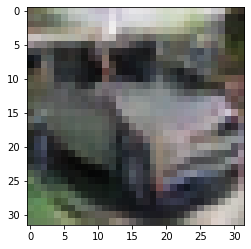


---------- Imagem gerada na epoch 463  ----------


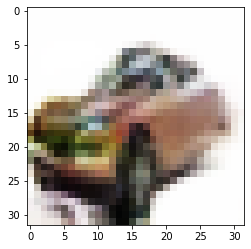


---------- Imagem gerada na epoch 464  ----------


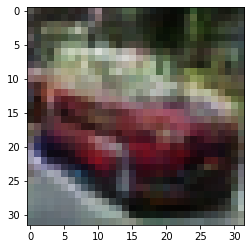


---------- Imagem gerada na epoch 465  ----------


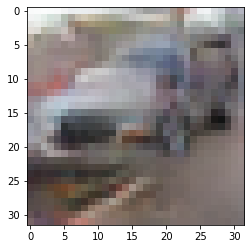


---------- Imagem gerada na epoch 466  ----------


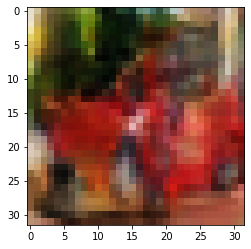


---------- Imagem gerada na epoch 467  ----------


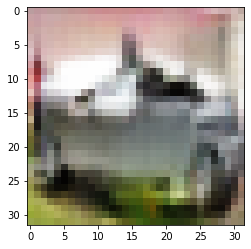


---------- Imagem gerada na epoch 468  ----------


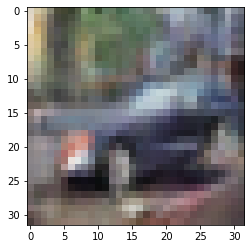


---------- Imagem gerada na epoch 469  ----------


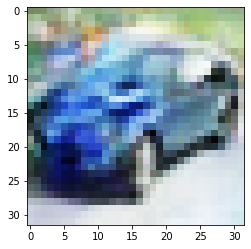


---------- Imagem gerada na epoch 470  ----------


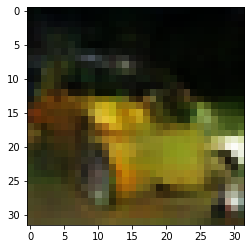


---------- Imagem gerada na epoch 471  ----------


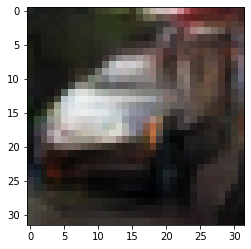


---------- Imagem gerada na epoch 472  ----------


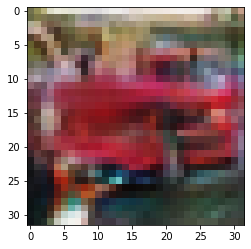


---------- Imagem gerada na epoch 473  ----------


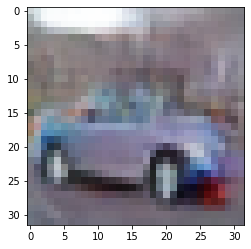


---------- Imagem gerada na epoch 474  ----------


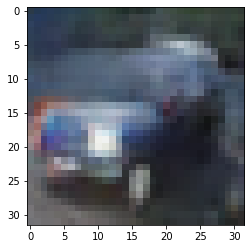


---------- Imagem gerada na epoch 475  ----------


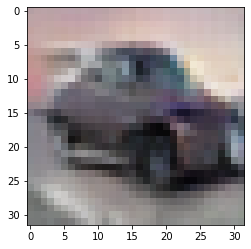


---------- Imagem gerada na epoch 476  ----------


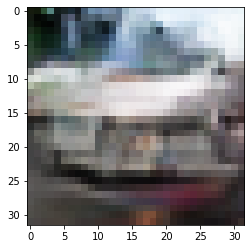


---------- Imagem gerada na epoch 477  ----------


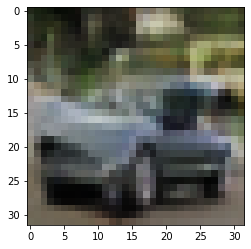


---------- Imagem gerada na epoch 478  ----------


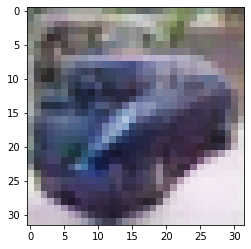


---------- Imagem gerada na epoch 479  ----------


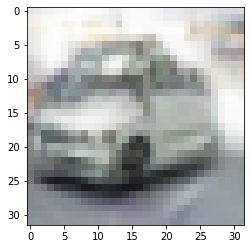


---------- Imagem gerada na epoch 480  ----------


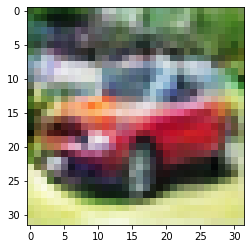


---------- Imagem gerada na epoch 481  ----------


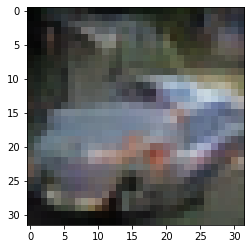


---------- Imagem gerada na epoch 482  ----------


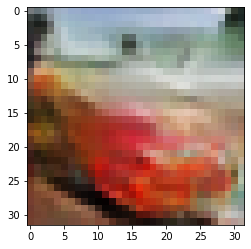


---------- Imagem gerada na epoch 483  ----------


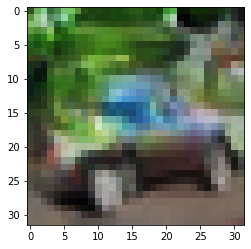


---------- Imagem gerada na epoch 484  ----------


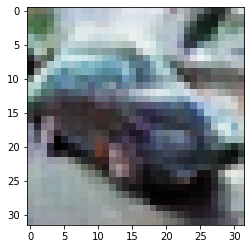


---------- Imagem gerada na epoch 485  ----------


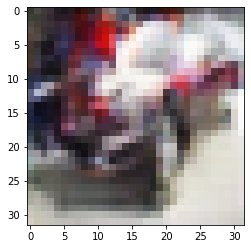


---------- Imagem gerada na epoch 486  ----------


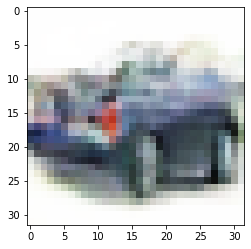


---------- Imagem gerada na epoch 487  ----------


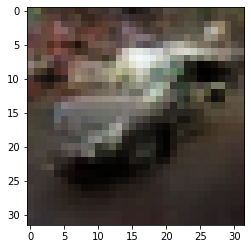


---------- Imagem gerada na epoch 488  ----------


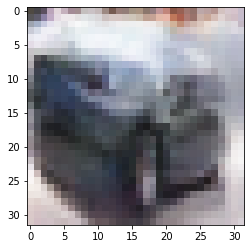


---------- Imagem gerada na epoch 489  ----------


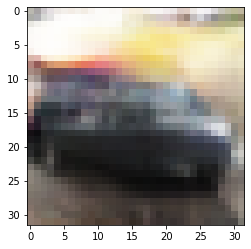


---------- Imagem gerada na epoch 490  ----------


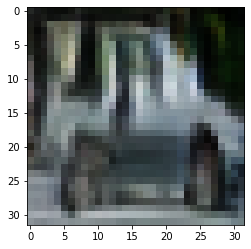


---------- Imagem gerada na epoch 491  ----------


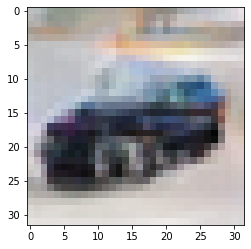


---------- Imagem gerada na epoch 492  ----------


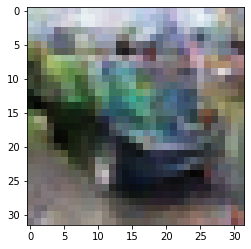


---------- Imagem gerada na epoch 493  ----------


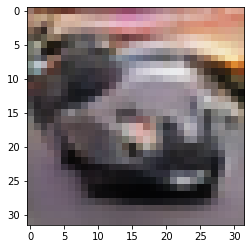


---------- Imagem gerada na epoch 494  ----------


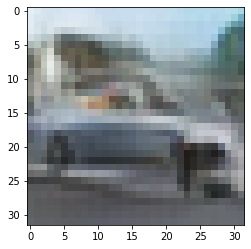


---------- Imagem gerada na epoch 495  ----------


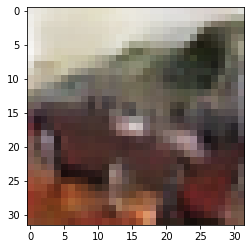


---------- Imagem gerada na epoch 496  ----------


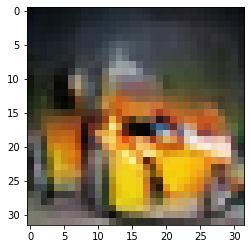


---------- Imagem gerada na epoch 497  ----------


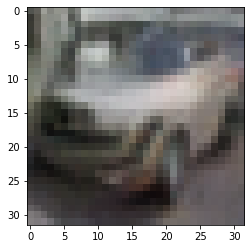


---------- Imagem gerada na epoch 498  ----------


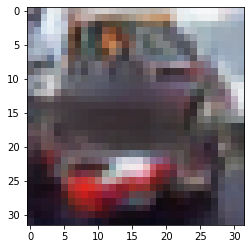


---------- Imagem gerada na epoch 499  ----------


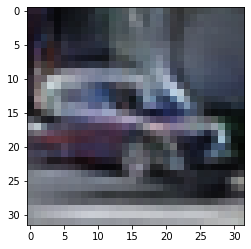

In [20]:
# Carregando os dados de imagens reais
#dataset = load_real_samples(train_batch)
dataset = load_real_samples()


# Treinando os modelos compilados
train(generator_model, discriminator_model, gan_model, dataset, latent_dim)


# Salvando o modelo treinado
generator_model.save('generator_model_cifar10_cars.h5')

# Parte 4: Usando o modelo gerador para gerar as imagens
Vamos visualizar as imagens do modelo treinado.

In [21]:
# Plotando as imagens geradas
def create_plot(examples, n):
    # plot images
    for i in range(n * n):
        # Definindo os subplots
        plt.subplot(n, n, 1 + i)
        
        # Removendo os eixos
        plt.axis('off')
        
        # Adicionando os graficos ao plot
        plt.imshow(examples[i, :, :])
        
    # Mostrando o plot final
    plt.show()

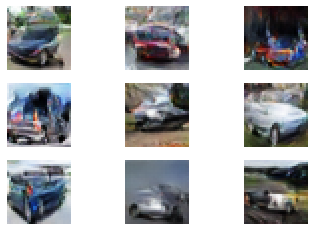

In [22]:
# Carregando o modelo, se necessário
model = load_model('generator_model_cifar10_cars.h5')

# Gerando os pontos latentes
latent_points = generate_latent_points(100, 100)

# Gerando as imagens
imgs = model.predict(latent_points)

# Trazendo os valores de volta para a escala (0, 1), pois eles estão em [-1, 1]
imgs = (imgs + 1) / 2.0

# Plotando 9 imagens (3 linhas x 3 colunas)
create_plot(imgs, 3)

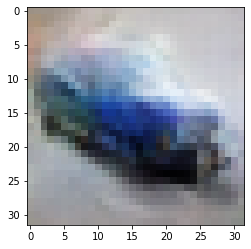

In [23]:
# Plotando uma imagem única gerada pelo modelo.
# O exemplo abaixo gera uma única imagem usando um vetor com todos os valores em 0.75

# Criando o vetor de pontos aleatórios no espaço latente
vector = generate_latent_points(100, 100)

# Gerando a imagem baseada nesses pontos
generated_img = model.predict(vector)

# Trazendo os valores da img. gerada volta para a escala (0, 1), pois eles estão em [-1, 1]
generated_img = (generated_img + 1) / 2.0

# Plotando a imagem
plt.imshow(generated_img[0, :, :])
plt.show()